# Notes about the code:
- I tried to make the code **modular** as i can
- Increase the **resuablity** and **scalabilty**

In [1]:
# Essential libraries for data manipulation, modeling, and visualization in this project.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.spatial import distance
import numpy as np
from scipy.stats import boxcox
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, mean_squared_error, log_loss, roc_curve, auc, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import permutation_importance
from scipy.stats import randint, uniform

In [2]:
# Load the dataset
data = pd.read_csv('recipe_site_traffic_2212.csv')

# Display the first few rows of the dataset
data.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


From the above, we can deduce that some columns contain missing data (e.g., **calories**, **carbohydrate**, **sugar**, **protein**, **high_traffic**). Additionally, the **servings** column might have _inconsistent data types_. (even though we'd expect this to be _numerical_, it's currently **object** type, suggesting there might be some **non-numeric values**)

Let's start with the recipe column and ensure all values are unique.

In [4]:
# Check if all recipe values are unique
are_recipe_unique = data['recipe'].nunique() == len(data)

are_recipe_unique

True

Next, let's check the **calories**, **carbohydrate**, **sugar**, and **protein** columns for **negative**, **zero** and **missing values**.

In [5]:
# Check for negative, zero, and missing values for each specified column in a systematic manner
cols_to_check = ['calories', 'carbohydrate', 'sugar', 'protein']

validation_summary = {}
for col in cols_to_check:
    negative_count = data[data[col] < 0][col].count() if data[col].min() < 0 else 0
    zero_count = (data[col] == 0).sum()
    missing_count = data[col].isnull().sum()
    validation_summary[col] = {
        "negative_values": negative_count,
        "zero_values": zero_count,
        "missing_values": missing_count
    }

validation_summary

{'calories': {'negative_values': 0, 'zero_values': 0, 'missing_values': 52},
 'carbohydrate': {'negative_values': 0,
  'zero_values': 0,
  'missing_values': 52},
 'sugar': {'negative_values': 0, 'zero_values': 0, 'missing_values': 52},
 'protein': {'negative_values': 0, 'zero_values': 2, 'missing_values': 52}}

# Data Validation:

This data set has **947 rows, 8 columns**,

- **recipe:** 947 unique values without missing values. No cleaning is needed.
- **calories:** 891 unique values with 52 missing values. **Cleaning might be needed.**
- **carbohydrate**: 835 unique values with 52 missing values. **Cleaning might be needed**.
- **sugar:** 666 unique values with 52 missing values. **Cleaning might be needed**.
- **protein:** 772 unique values with 52 missing values. **Cleaning might be needed**.
- **category:** 11 categories without missing values, including Pork, Potato, Breakfast, Beverages, One Dish Meal, Chicken Breast, Lunch/Snacks, Chicken, Vegetable, Meat, Dessert. No cleaning is needed.
- **servings:** 6 unique values without missing values, including 6, 4, 1, 2, **'4 as a snack'**, **'6 as a snack'**. **Cleaning might be needed to ensure consistent numeric format**.
- **high_traffic:** 1 unique value with 373 missing values. **Cleaning might be needed**.
And there is **no negative values** at all in the dataset,
I sumarized the above information in the table below:

In [6]:
# Creating the data validation summary DataFrame
data_validation_df = pd.DataFrame({
    'Column Name': data.columns,
    'Unique Values': [data[col].nunique() for col in data.columns],
    'Missing Values': [data[col].isnull().sum() for col in data.columns],
    'Sample Values': [data[col].dropna().unique()[:3].tolist() for col in data.columns]  # Taking first 3 unique values as samples
})

data_validation_df

,Column Name,Unique Values,Missing Values,Sample Values
0,recipe,947,0,"[1, 2, 3]"
1,calories,891,52,"[35.48, 914.28, 97.03]"
2,carbohydrate,835,52,"[38.56, 42.68, 30.56]"
3,sugar,666,52,"[0.66, 3.09, 38.63]"
4,protein,772,52,"[0.92, 2.88, 0.02]"
5,category,11,0,"[Pork, Potato, Breakfast]"
6,servings,6,0,"[6, 4, 1]"
7,high_traffic,1,373,[High]


Due to the consistent pattern of missing values across different columns, it's possible that these missing values are related. we will check that now.

In [7]:
# Find indices with non-mutual missing values
missing_sums_subset = data[cols_to_check].isna().sum(axis=1)
non_mutual_missing_indices = missing_sums_subset[(missing_sums_subset > 0) & (missing_sums_subset < len(cols_to_check))].index

print(non_mutual_missing_indices)

Int64Index([], dtype='int64')


As we have seen that all the missing values across the columns have **the same indecies**. the code above have already checked that for us.

In [8]:
missing_rows = data[data[['calories', 'carbohydrate', 'sugar', 'protein']].isnull().any(axis=1)]
missing_rows

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
23,24,NaN,NaN,NaN,NaN,Meat,2,NaN
48,49,NaN,NaN,NaN,NaN,Chicken Breast,4,NaN
82,83,NaN,NaN,NaN,NaN,Meat,4,High
89,90,NaN,NaN,NaN,NaN,Pork,6,High
116,117,NaN,NaN,NaN,NaN,Chicken Breast,6,High
121,122,NaN,NaN,NaN,NaN,Dessert,2,High
136,137,NaN,NaN,NaN,NaN,One Dish Meal,2,High
149,150,NaN,NaN,NaN,NaN,Potato,2,High
187,188,NaN,NaN,NaN,NaN,Pork,4,High


Given the nature of our dataset, I'd recommend trying the **Group-based Imputation** approach using the "**category**" column. We can fill the missing values of **calories**, **carbohydrate**, **sugar**, and **protein** based on the **mean** of their respective **category**.

## Applying Group-based Imputation:

In [9]:
# List of columns to fill missing values
cols_to_fill = ['calories', 'carbohydrate', 'sugar', 'protein']

# Group by 'category' and compute the mean for each column in cols_to_fill
grouped_means = data.groupby('category')[cols_to_fill].transform('mean')

# Use the grouped means to fill the missing values
data[cols_to_fill] = data[cols_to_fill].fillna(grouped_means)

In [10]:
data.isnull().sum()

recipe            0
calories          0
carbohydrate      0
sugar             0
protein           0
category          0
servings          0
high_traffic    373
dtype: int64

In [11]:
# Check unique values in the 'category' column
unique_categories = data['category'].unique()

unique_categories

array(['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal',
       'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat',
       'Dessert'], dtype=object)

At first glance, these categories seem consistent without any obvious typos or misclassifications.

Next, let's validate the **servings** column. Since it's currently of **object** type, we should convert it to numeric and **identify any non-numeric values**.

In [12]:
# Try converting the 'servings' column to numeric and identify non-numeric values
data['servings'].unique()                                        

array(['6', '4', '1', '2', '4 as a snack', '6 as a snack'], dtype=object)

We have identified non-numeric values: '4 as a snack' and '6 as a snack', we will extract numeric values from them.

In [13]:
# Use regular expressions to extract numeric values from the 'servings' column
data['servings'] = data['servings'].str.extract('(\d+)').astype(float)
data['servings'].unique()

array([6., 4., 1., 2.])

let's validate the 'high_traffic' column. We will:
- Check for unique values to ensure consistency.
- Address the missing values.

In [14]:
# Check unique values and missing values in the 'high_traffic' column
unique_high_traffic = data['high_traffic'].unique()
missing_high_traffic = data['high_traffic'].isnull().sum()

unique_high_traffic, missing_high_traffic

(array(['High', nan], dtype=object), 373)

From the given unique values, it's likely that the column is **binary**, with "High" indicating high traffic and **NaN** (or **possibly another value**) indicating **low** or **standard traffic**. The **absence** of a "Low" or equivalent category suggests that the missing values might represent **non-high** traffic recipes.

In [15]:
# Replace NaN values in the 'high_traffic' column with 'Low'
data['high_traffic'].fillna('Low', inplace=True)
data.isnull().sum()

recipe          0
calories        0
carbohydrate    0
sugar           0
protein         0
category        0
servings        0
high_traffic    0
dtype: int64

In [16]:
def standardize_decimal_places_df(df, columns, decimal_places=2):
    """
    Standardize the number of decimal places for specified columns in a DataFrame.
    
    Args:
    - df (DataFrame): Input DataFrame.
    - columns (list): List of column names to be standardized.
    - decimal_places (int): The desired number of decimal places.
    
    Returns:
    - DataFrame: DataFrame with specified columns having standardized decimal places.
    """
    for col in columns:
        if col in df.columns:
            df[col] = df[col].round(decimal_places)
    return df

In [17]:
data = standardize_decimal_places_df(data, data[['calories', 'carbohydrate', 'sugar', 'protein']])

# DATA VISUALIZATION:

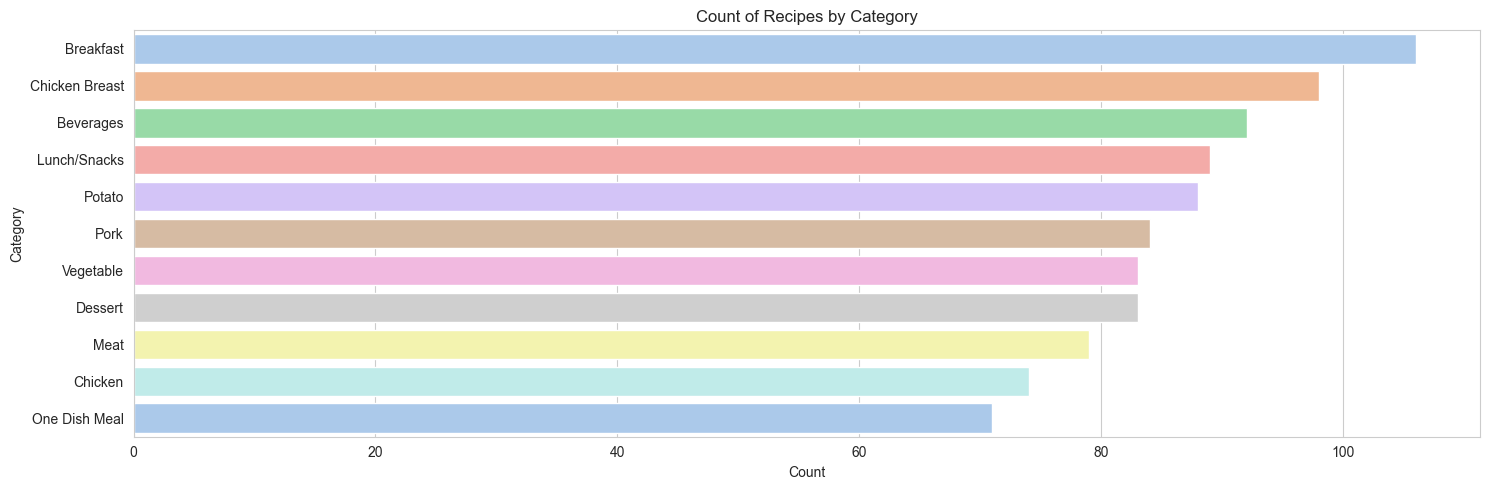

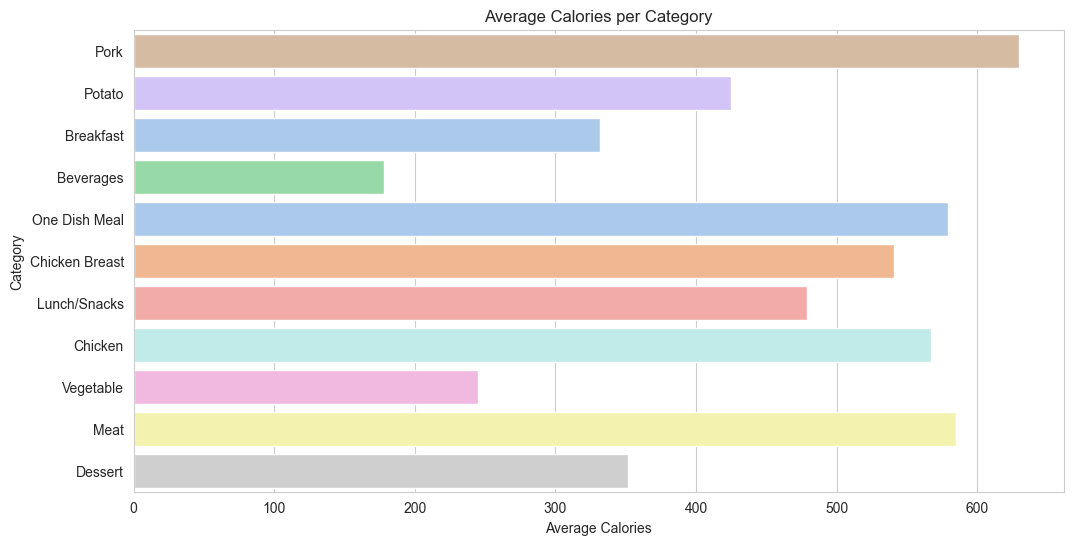

In [18]:
# Set style for seaborn
sns.set_style("whitegrid")

# Step 1: Create a fixed color palette
unique_categories = data['category'].unique()
palette = sns.color_palette('pastel', n_colors=len(unique_categories))

# Step 2: Assign each category a color
color_mapping = dict(zip(data['category'].value_counts().index, palette))

# Create a single subplot
fig, ax = plt.subplots(figsize=(15, 5))

# Plot a bar chart for the 'category' column
sns.countplot(y=data['category'], ax=ax, palette=color_mapping, order=data['category'].value_counts().index)
ax.set_title('Count of Recipes by Category')
ax.set_xlabel('Count')
ax.set_ylabel('Category')

# Adjust layout
plt.tight_layout()
plt.show()

# Plotting the second visualization
plt.figure(figsize=(12, 6))
sns.barplot(y='category', x='calories', data=data, ci=None, palette=color_mapping)
plt.title('Average Calories per Category')
plt.xlabel('Average Calories')
plt.ylabel('Category')
plt.show()

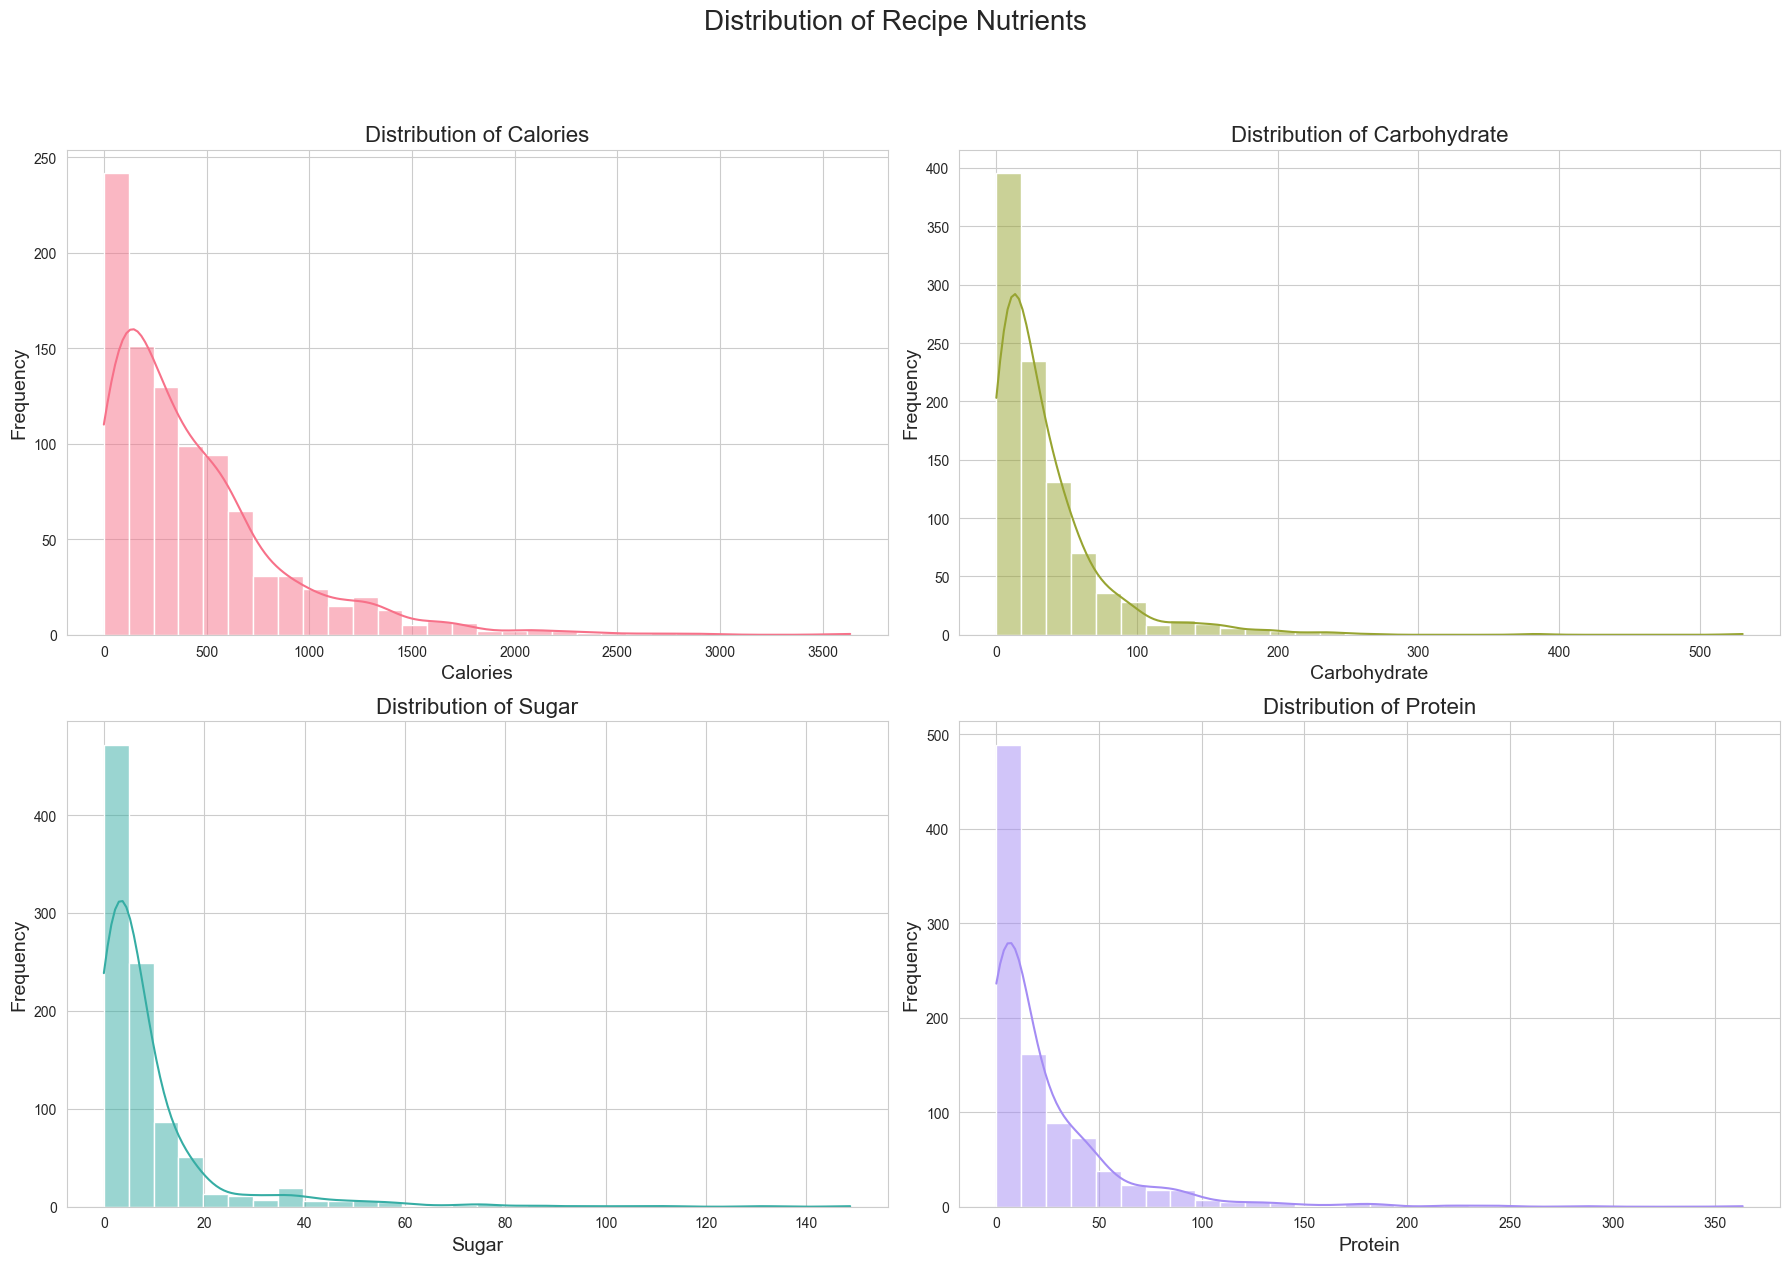

In [19]:
# Set the style and color palette
sns.set_style("whitegrid")
color_palette = sns.color_palette("husl", 4)  # "husl" is a perceptually uniform color palette

# Create a figure with multiple subplots
fig, ax = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Distribution of Recipe Nutrients', fontsize=20, y=1.05)

# Plot histograms for each column
cols_to_plot = ['calories', 'carbohydrate', 'sugar', 'protein']
for i, col in enumerate(cols_to_plot):
    sns.histplot(data[col], ax=ax[i//2, i%2], color=color_palette[i], kde=True, bins=30)
    ax[i//2, i%2].set_title(f'Distribution of {col.capitalize()}', fontsize=16)
    ax[i//2, i%2].set_ylabel('Frequency', fontsize=14)
    ax[i//2, i%2].set_xlabel(col.capitalize(), fontsize=14)

plt.tight_layout()
plt.show()

# Outlier Detection:

- It's implausible for a row to have calories lower than any of the other numeric attributes such as protein, carbohydrate, or sugar.

In [20]:
 def detect_invalid_indices(df):
    lower_calories_indices = df[
        (df['calories'] < df['sugar']) | 
        (df['calories'] < df['protein']) | 
        (df['calories'] < df['carbohydrate'])
    ].index
    
    return lower_calories_indices

In [21]:
var_lower_calories_indices = detect_invalid_indices(data)
data.loc[var_lower_calories_indices]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4.0,High
20,21,9.26,17.44,8.16,10.81,Potato,6.0,High
21,22,40.53,87.91,104.91,11.93,Dessert,4.0,Low
29,30,164.76,33.58,17.87,220.14,One Dish Meal,2.0,High
37,38,44.55,99.82,2.62,15.57,Breakfast,4.0,Low
...,...,...,...,...,...,...,...,...
878,879,88.26,18.58,5.21,99.64,Meat,6.0,High
886,887,30.37,38.40,0.10,35.20,Vegetable,2.0,High
905,906,42.30,12.14,1.86,87.25,Chicken Breast,2.0,Low
922,923,27.65,31.14,3.60,8.66,Potato,4.0,High


In [22]:
data = data.drop(var_lower_calories_indices).reset_index(drop=True)

In [23]:
def identify_outliers(df, columns):
    """
    Identify outliers from the specified columns using the IQR method.

    Parameters:
    - df: DataFrame
    - columns: list of columns from which to identify outliers

    Returns:
    - Dictionary where keys are column names and values are DataFrames containing outlier rows
    """
    outliers_dict = {}
    
    for col in columns:
        # Compute Q1, Q3, and IQR
        Q1 = df[col].quantile(0.03)
        Q3 = df[col].quantile(0.97)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        
        # Add outliers to dictionary
        outliers_dict[col] = outliers
    
    return outliers_dict

numeric_columns = ['sugar', 'protein', 'carbohydrate', 'calories']
# Identify outliers
outliers_data = identify_outliers(data, numeric_columns)
# Consolidate outliers from all columns into a single DataFrame
outliers_df = pd.concat(outliers_data.values()).drop_duplicates()

outliers_df

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
260,291,239.90,51.13,131.39,3.38,Dessert,2.0,High
620,696,891.11,15.20,1.50,286.97,Chicken,2.0,Low
764,862,1646.67,9.42,5.12,245.57,Chicken Breast,6.0,High


In [24]:
data = data.drop(outliers_df.index).reset_index(drop=True)

In [25]:
# Create the interactive 3D scatter plot
fig = px.scatter_3d(data, 
                    x='protein', 
                    y='carbohydrate', 
                    z='calories', 
                    color='high_traffic',
                    size='sugar',
                    hover_data=['category'],
                    color_discrete_map={"High": "gold", "Low": "blue"},
                    labels={'calories': 'Calories', 'carbohydrate': 'Carbohydrates', 'protein': 'Protein', 'sugar': 'Sugar'},
                    title="3D Scatter Plot of Nutritional Content by Traffic Level"
                   )

# Show the plot
fig.show()

In [26]:
# Create the interactive bubble chart
bubble_chart = px.scatter(data, 
                          x='calories', 
                          y='protein', 
                          size='sugar', 
                          color='high_traffic',
                          hover_data=['category'],
                          color_discrete_map={"High": "gold", "Low": "blue"},
                          labels={'calories': 'Calories', 'protein': 'Protein', 'sugar': 'Sugar'},
                          title="Bubble Chart: Calories vs. Protein, sized by Sugar Content",
                          size_max=60  # Adjusting the maximum size of the bubble for better visualization
                         )

# Show the bubble chart
bubble_chart.show()

# Feature Engineering:

The introduction of the sugar_to_calories column serves as a crucial metric to capture the relative sugar content of a recipe in relation to its overall caloric value. As health and dietary considerations become increasingly paramount among consumers, understanding **the sugar concentration in foods** is vital. A higher sugar-to-calorie ratio could indicate recipes that are more dessert-like or indulgent, whereas a lower ratio might signify recipes that provide more balanced energy. This derived feature can offer a nuanced perspective on the health implications of a recipe, potentially correlating with its popularity or traffic. By analyzing this ratio, we aim to discern patterns or preferences in user behavior and recipe selection, making our dataset richer and more insightful for subsequent analyses.

In [27]:
data['sugar_to_calories'] = data['sugar'] / data['calories']

### Apply The Pearson correlation coefficient (Heatmap) for numeric features before transformation:

It's beneficial to plot correlation heatmaps **both before and after transformations**. This way, we can compare and understand how the transformation affects the linear relationships between variables. If we're using the correlation heatmap to inform feature selection or understand multicollinearity ahead of linear modeling, then it's particularly important to look at the heatmap after transformation, as this represents the data that the model will see.

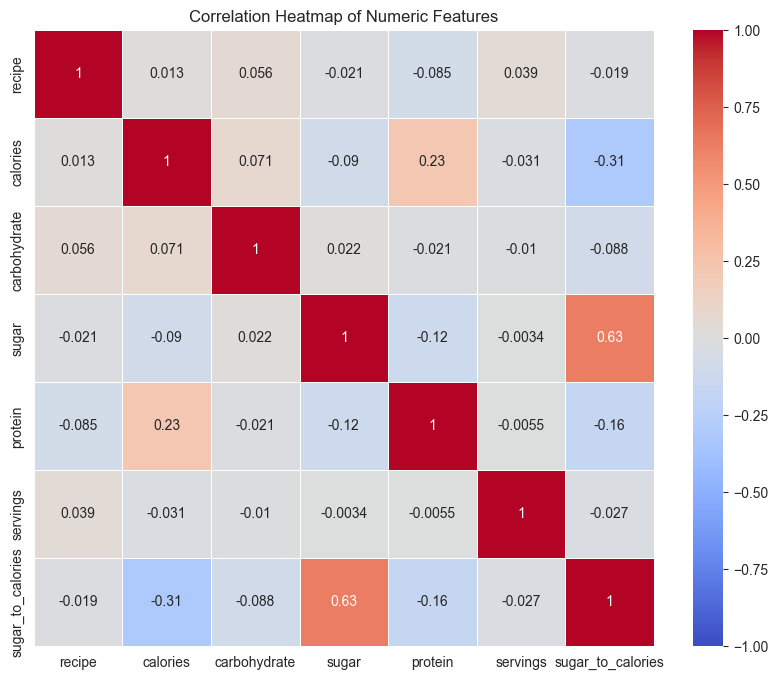

In [28]:
# Compute the correlation matrix for numeric columns
corr_matrix_before = data.select_dtypes(include=['float64', 'int64']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a heatmap
sns.heatmap(corr_matrix_before, annot=True, cmap='coolwarm', linewidths=.5, vmin=-1, vmax=1)

# Display the plot
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

## Box-Cox Transformation:

- The Box-Cox transformation is applied to **stabilize variance** and make the data more **Gaussian-like**. 
- Given that many statistical techniques assume **constant variance and normally distributed data**, the Box-Cox transformation is crucial to meet these assumptions, **especially for linear models**.
- This transformation addresses the **non-linearity** and **heteroskedasticity** in the specified columns, ensuring that the subsequent analysis and modeling are based on data that adheres more closely to key statistical assumptions.


In [29]:
cols_to_transform = ['calories', 'carbohydrate', 'sugar', 'protein', 'sugar_to_calories']

# Create a dictionary to store lambda values for each column
lambdas = {}

for col in cols_to_transform:
    # Check for non-positive values
    if data[col].min() <= 0:
        # Add a constant to make all values positive. The constant is 1 minus the minimum value.
        data[col] = data[col] + abs(data[col].min()) + 1
    
    # Apply Box-Cox transformation
    data[col], lam = boxcox(data[col])
    
    # Store the lambda value used for the transformation for later usage if needed.
    lambdas[col] = lam

lambdas

{'calories': 0.17605699734046656,
 'carbohydrate': 0.23943232860889346,
 'sugar': 0.12175620610686429,
 'protein': 0.051918705190650206,
 'sugar_to_calories': 0.030387647419414583}

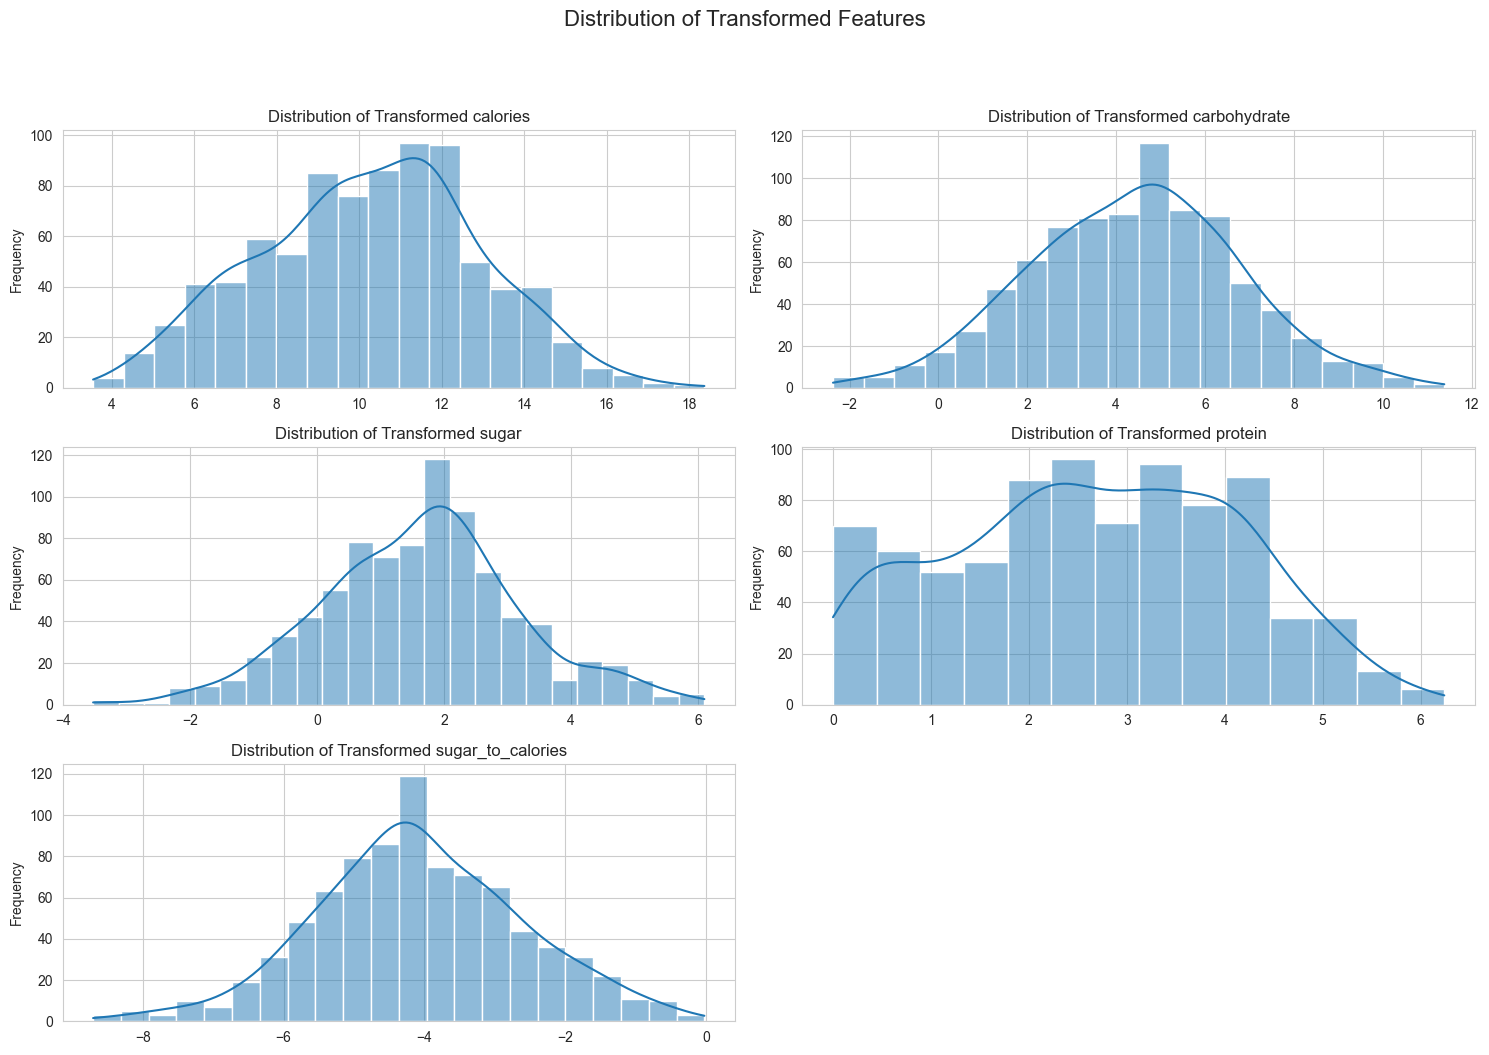

In [30]:
# Set the style for the plots
sns.set_style("whitegrid")

# Create a figure with multiple subplots
fig, ax = plt.subplots(3, 2, figsize=(15, 10))
fig.suptitle('Distribution of Transformed Features', fontsize=16, y=1.05)

# Plot histograms for each transformed column
for i, col in enumerate(cols_to_transform):
    sns.histplot(data=data, x=col, kde=True, ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'Distribution of Transformed {col}')
    ax[i//2, i%2].set_ylabel('Frequency')
    ax[i//2, i%2].set_xlabel('')

# Hide the last unused subplot
ax[2, 1].axis('off')

plt.tight_layout()
plt.show()

## **Mahalanobis Distance** for detecting outliers: 
But why Mahalanobis Distance?

- **Scale-Invariance**: Accounts for feature variance; no need for normalization.
- **Correlation Consideration**: Incorporates feature interrelations, capturing data's true structure.
- **Multivariate Analysis**: Identifies outliers by assessing all features collectively.
- **Robustness**: Adjusts to diverse feature scales, ensuring consistent outlier identification.

In [31]:
def compute_mahalanobis(df):
    """
    Compute the Mahalanobis Distance for each observation in the dataset.
    
    Parameters:
    - data: DataFrame or 2D numpy array, numeric data to compute distances for
    
    Returns:
    - mahalanobis_distances: list of Mahalanobis distances for each observation
   """
    
    # Convert dataframe to numpy array if necessary
    if isinstance(df, pd.DataFrame):
        df = df.values

    # Calculate the inverse of the covariance matrix
    cov_matrix = np.cov(df, rowvar=False)
    inv_cov_matrix = np.linalg.inv(cov_matrix)

    # Calculate the mean values
    mean_values = np.mean(df, axis=0)

    # Compute the Mahalanobis distance for each observation
    mahalanobis_distances = []
    for row in df:
        mahalanobis_dist = distance.mahalanobis(row, mean_values, inv_cov_matrix)
        mahalanobis_distances.append(mahalanobis_dist)

    return mahalanobis_distances

In [32]:
numeric_data = data[['calories', 'carbohydrate', 'sugar', 'protein']]

# Using the function to compute Mahalanobis distances
distances = compute_mahalanobis(numeric_data.values)  # Assuming 'numeric_data' contains the numeric columns

# Set the threshold for outliers based on 97% quantile (or adjust as needed)
threshold = np.percentile(distances, 99.5)

# Identify and count outlier rows
outlier_rows = np.where(np.array(distances) > threshold)[0]
num_outliers = len(outlier_rows)

print(f"Number of outliers identified: {num_outliers}")

Number of outliers identified: 5


In [33]:
data.loc[outlier_rows]

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic,sugar_to_calories
16,18,15.353040,-1.770051,-0.889637,3.875797,Meat,1.0,High,-7.396192
164,186,14.300098,9.777555,-0.511042,0.382179,Lunch/Snacks,4.0,High,-6.843202
618,695,14.521037,9.735313,-1.693955,1.312550,One Dish Meal,2.0,High,-7.953059
750,848,6.817835,6.447429,-3.525038,0.339428,Beverages,6.0,Low,-7.938375
820,926,18.372493,5.182106,-0.985496,1.238133,Chicken,4.0,Low,-8.061933


### Apply the Pearson correlation coefficient (Heatmap) for numeric features after transformation:

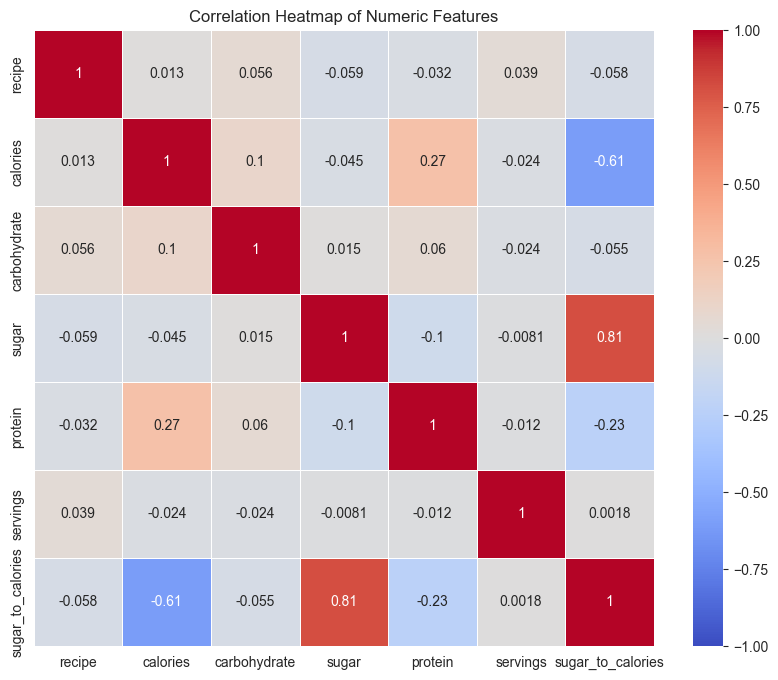

In [35]:
# Compute the correlation matrix for numeric columns
corr_matrix_after = data.select_dtypes(include=['float64', 'int64']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Generate a heatmap
sns.heatmap(corr_matrix_after, annot=True, cmap='coolwarm', linewidths=.5, vmin=-1, vmax=1)

# Display the plot
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

### Key Observations (comparing the heatmap before and after the transformation):
1. First and Second Variables: The correlation has slightly decreased from 0.00627249 to 0.0007567 post-transformation.
2. Second and Seventh Variables: The correlation has notably changed from -0.07620034 to -0.675793389 .
3. Fourth and Seventh Variables: The correlation has increased significantly from 0.13112535 to 0.737715044 .
In summary, the transformation has altered the linear relationships between some variable pairs.

## Categorical Binning:

Categorical binning, or **discretization**, is a powerful technique employed to transform continuous variables into categorical counterparts, making them more interpretable and easier to analyze.

In [36]:
# Define a function to bin continuous variables
def bin_values_3_categories(col):
    # Determine the quantiles
    q1, q3 = col.quantile([0.33, 0.66])
    
    # Bin values based on quantiles
    bins = ['Low' if x <= q1 else 'Medium' if x <= q3 else 'High' for x in col]
    return bins

In [37]:
# Apply binning to continuous columns
continuous_columns = ['sugar', 'protein', 'carbohydrate', 'calories']
for col in continuous_columns:
    data[col + '_3_bin'] = bin_values_3_categories(data[col])

# Model Development:
Within this section, the code has been structured for:
- **modularity**, **enhancing its reusability**
- **facilitating streamlined experimentation across diverse modeling algorithms**.

## Defining the necessary custom functions:

In [38]:
def prepare_data(df, target_col, drop_cols=[], test_size=0.2, random_state=42):
    """
    Prepare the data by encoding and splitting into training and test sets.
    
    Parameters:
    - data: The dataframe containing the dataset.
    - target_col: The column name of the target variable.
    - drop_cols: A list of columns to be dropped.
    - test_size: Proportion of the dataset to include in the test split.
    - random_state: Random state for reproducibility.
    
    Returns:
    - X_train, X_test, y_train, y_test: Training and testing data.
    - label_encoders: Dictionary of label encoders used for each column.
    """
    
    # Encoding categorical variables
    label_encoders = {}
    for column in df.select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df[column] = le.fit_transform(df[column])
        label_encoders[column] = le

    # Splitting the data into features and target
    X = df.drop(columns=drop_cols)
    y = df[target_col]

    # Splitting into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                        random_state=random_state, stratify=y)
    
    return X_train, X_test, y_train, y_test, label_encoders

In [39]:
def train_model(model, X_train, y_train):
    """
    Train the given model on the provided training data.
    
    Parameters:
    - model: The machine learning model to be trained.
    - X_train: Training data features.
    - y_train: Training data target.
    
    Returns:
    - Trained model.
    """
    model.fit(X_train, y_train)
    return model

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve, classification_report

def evaluate_model(model, X_test, y_test, binary_classification=True):
    """
    Evaluate the given model on the provided test data.
    
    Parameters:
    - model: The trained machine learning model.
    - X_test: Test data features.
    - y_test: Test data target.
    - binary_classification: Whether the task is binary classification or not.
    
    Returns:
    - Dictionary with evaluation metrics.
    """
    y_pred = model.predict(X_test)
    
    # Probabilities (useful for metrics like ROC AUC)
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'Log Loss': log_loss(y_test, y_proba) if y_proba is not None else None,
        'Classification Report': classification_report(y_test, y_pred, zero_division=0, output_dict=True)  # Add classification report here
    }
    
    if binary_classification and y_proba is not None:
        metrics['ROC AUC'] = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        metrics['fpr'] = fpr
        metrics['tpr'] = tpr
    
    return metrics

In [41]:
def visualize_metrics(model_metrics):
    """
    Visualize the evaluation metrics for all models.
    
    Parameters:
    - model_metrics: Dictionary containing evaluation metrics for each model.
    """
    
    # Set a modern style for the plots
    sns.set_style("whitegrid")
    
    metrics_to_visualize = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Log Loss']
    
    model_names = list(model_metrics.keys())
    
    for metric in metrics_to_visualize:
        plt.figure(figsize=(12, 7))
        
        values = [metrics[metric] for metrics in model_metrics.values()]
        
        bars = plt.bar(model_names, values, color=sns.color_palette('pastel', len(model_names)))
        
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, round(yval, 4), 
                     ha='center', va='bottom', color='black', weight='bold')
        
        plt.xlabel('Models', fontsize=14)
        plt.ylabel(metric, fontsize=14)
        plt.title(f'Model {metric} Comparison', fontsize=16)
        plt.xticks(fontsize=12, rotation=45)
        plt.yticks(fontsize=12)
        plt.tight_layout()
        plt.show()
    
    # ROC Curve visualization
    plt.figure(figsize=(12, 7))
    colors = sns.color_palette('husl', len(model_names))
    for idx, (model, metrics) in enumerate(model_metrics.items()):
        if 'fpr' in metrics and 'tpr' in metrics:
            plt.plot(metrics['fpr'], metrics['tpr'], color=colors[idx], lw=2, 
                     label=f'{model} (AUC = {metrics["ROC AUC"]:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc="lower right", fontsize=12)
    plt.tight_layout()
    plt.show()

    # Classification Report Heatmap Visualization
    for model, metrics in model_metrics.items():
        if 'Classification Report' in metrics:
            report = metrics['Classification Report']
            df = pd.DataFrame(report).transpose().drop(['support'], axis=1)
            plt.figure(figsize=(10, 6))
            sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=False, fmt=".2f")
            plt.title(f'Classification Report for {model}', fontsize=16)
            plt.show()

## Training and Evaluating our models:

Splitting the dataset into training and testing subsets for training our models and excluding target and 'recipe' columns.

In [42]:
X_train, X_test, y_train, y_test, label_encoders = prepare_data(data, target_col='high_traffic', drop_cols=['high_traffic', 'recipe'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((672, 11), (169, 11), (672,), (169,))

In [43]:
X_train

,calories,carbohydrate,sugar,protein,category,servings,sugar_to_calories,sugar_3_bin,protein_3_bin,carbohydrate_3_bin,calories_3_bin
428,11.431619,7.062835,0.242529,2.638015,5,1.0,-5.505558,1,2,0,2
201,7.770080,2.099776,-0.781282,4.536249,8,6.0,-5.248229,1,0,1,1
806,6.459181,1.252310,0.167193,0.199881,9,6.0,-3.897547,1,1,1,1
502,9.258356,5.161996,0.717784,2.396395,1,1.0,-4.470076,1,2,2,2
671,14.597402,4.275025,2.355065,4.063986,7,4.0,-4.773618,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
568,11.347554,6.417411,0.650408,2.226086,5,1.0,-5.157888,1,2,0,2
21,13.997259,0.447673,2.501666,2.792655,1,1.0,-4.529941,0,2,1,0
790,11.727965,6.499068,2.004297,3.969292,7,4.0,-4.265159,2,0,0,0
113,8.496926,3.008625,2.172035,3.023932,1,4.0,-3.111085,2,2,1,1


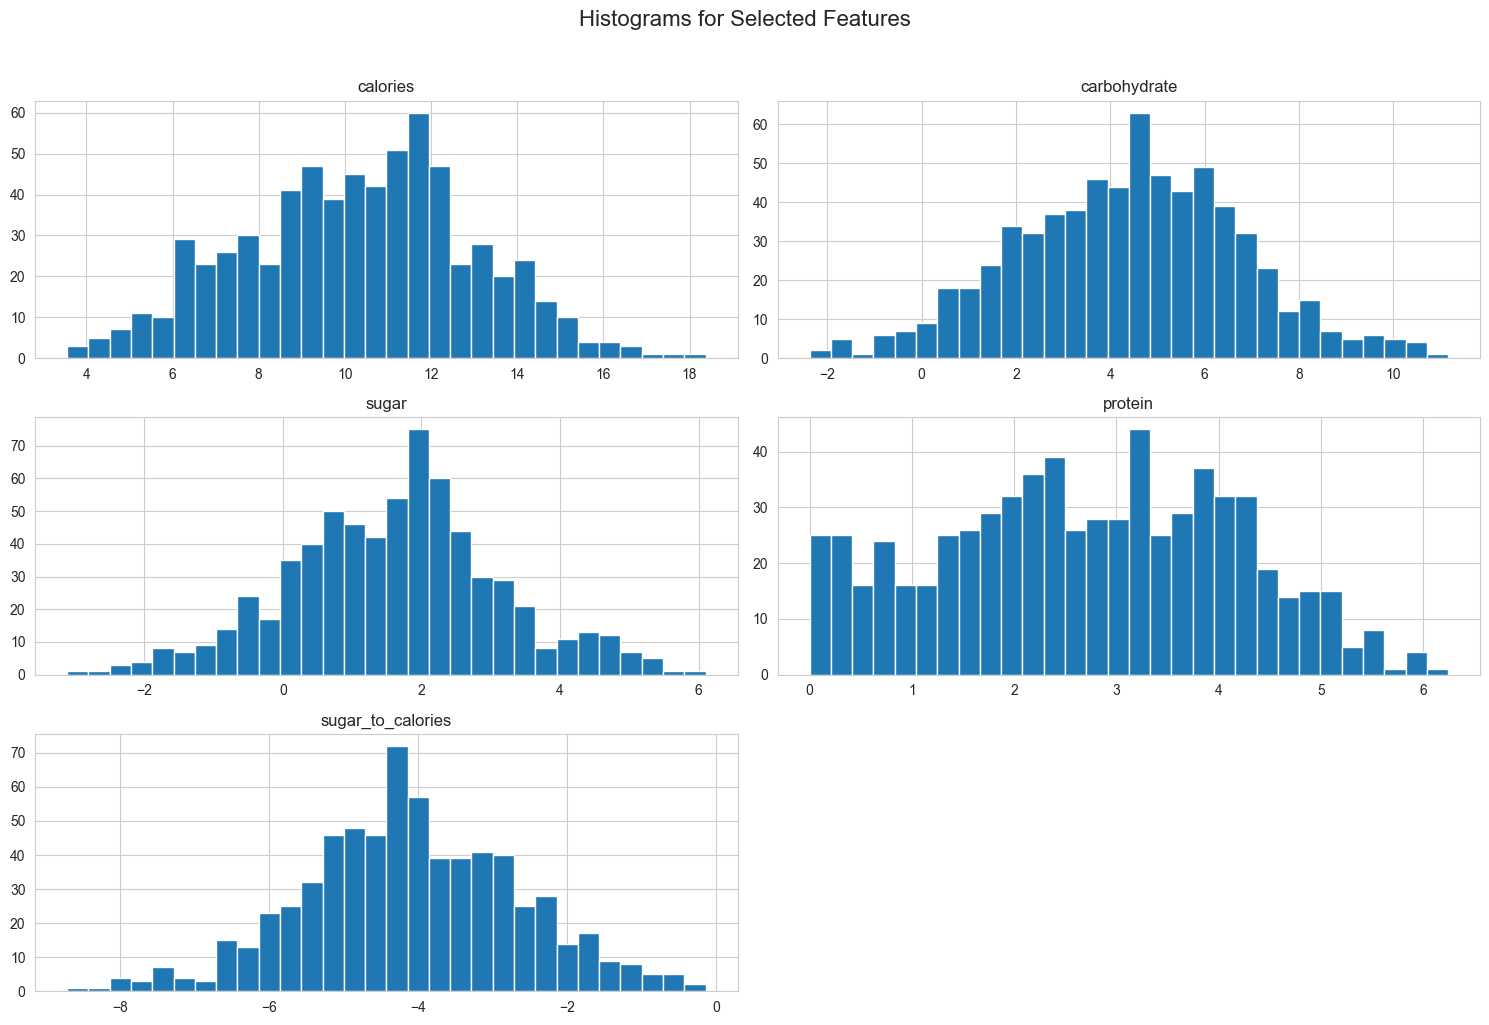

In [44]:
# Selecting the specified columns from the dataset
X_train_subset = X_train[['calories', 'carbohydrate', 'sugar', 'protein', 'sugar_to_calories']]

# Plotting histograms for each column in X_train_subset
X_train_subset.hist(figsize=(15, 10), bins=30)
plt.suptitle('Histograms for Selected Features', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

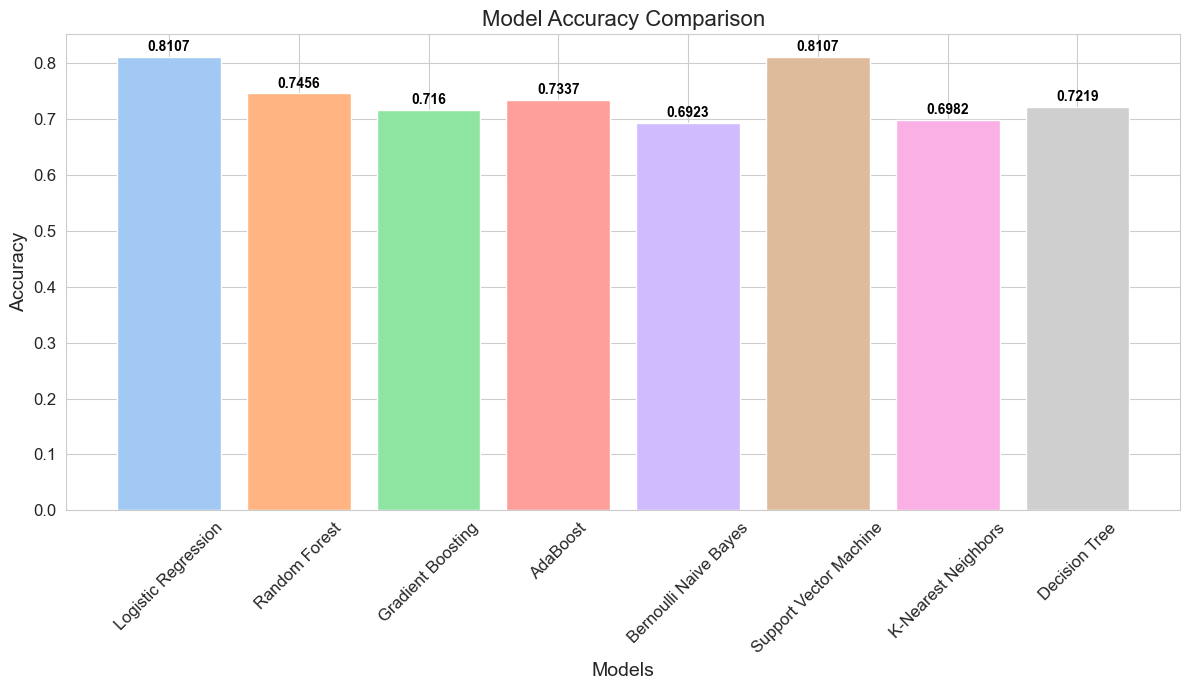

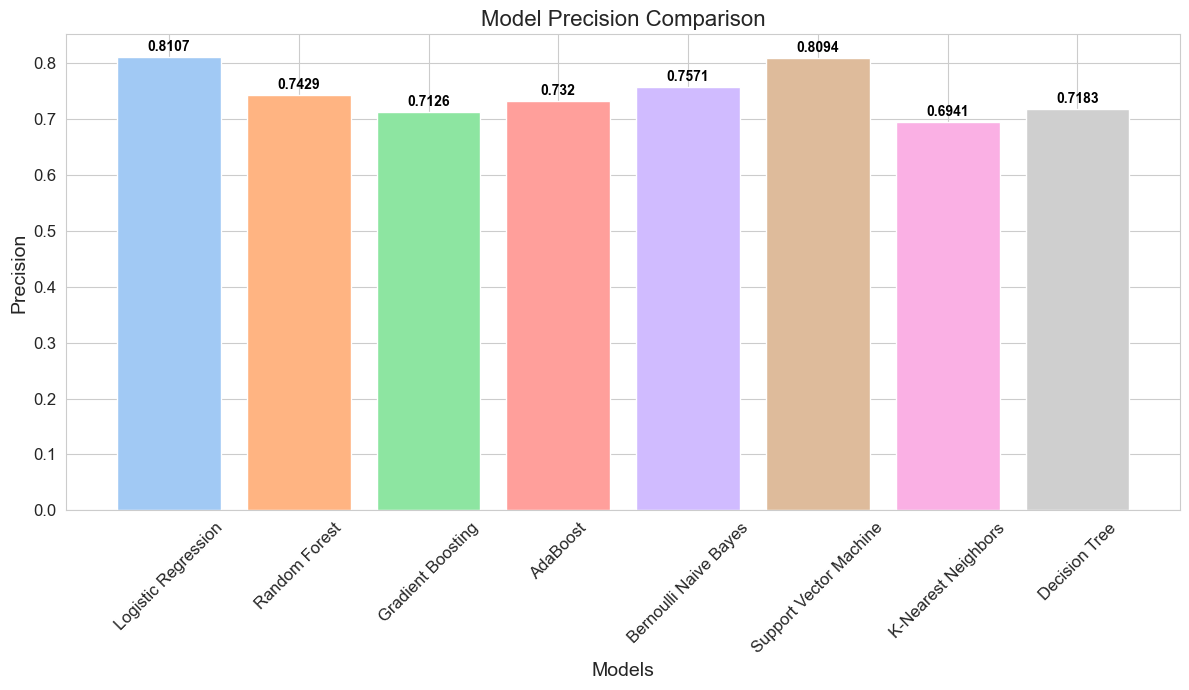

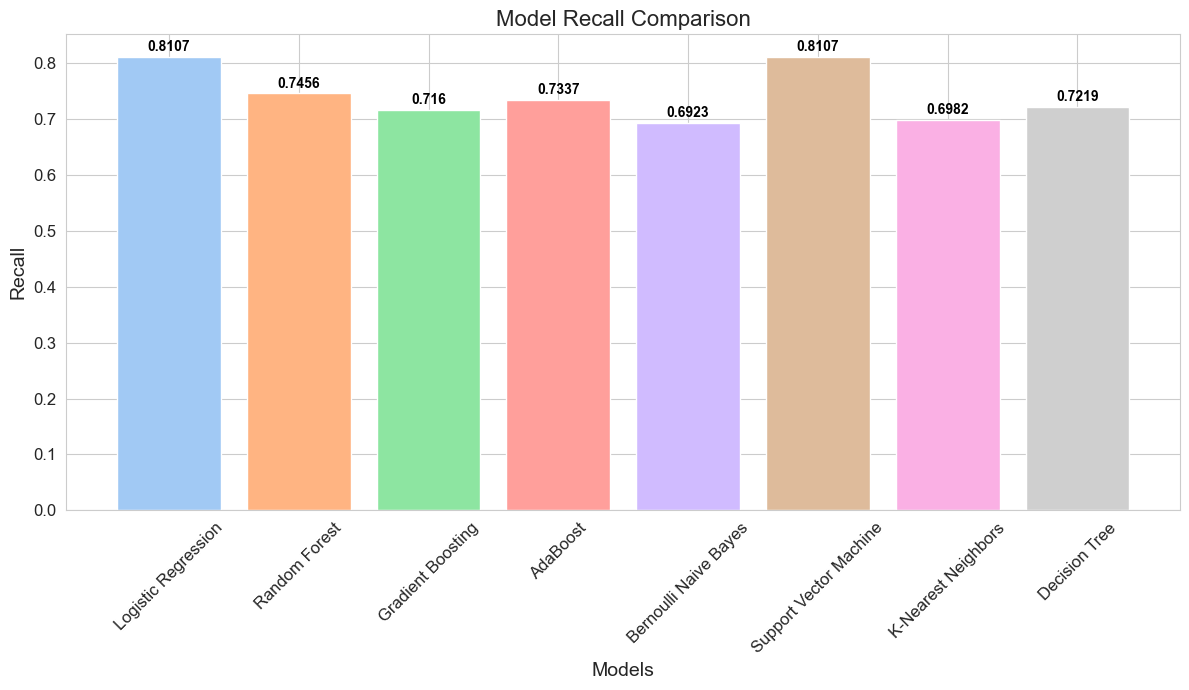

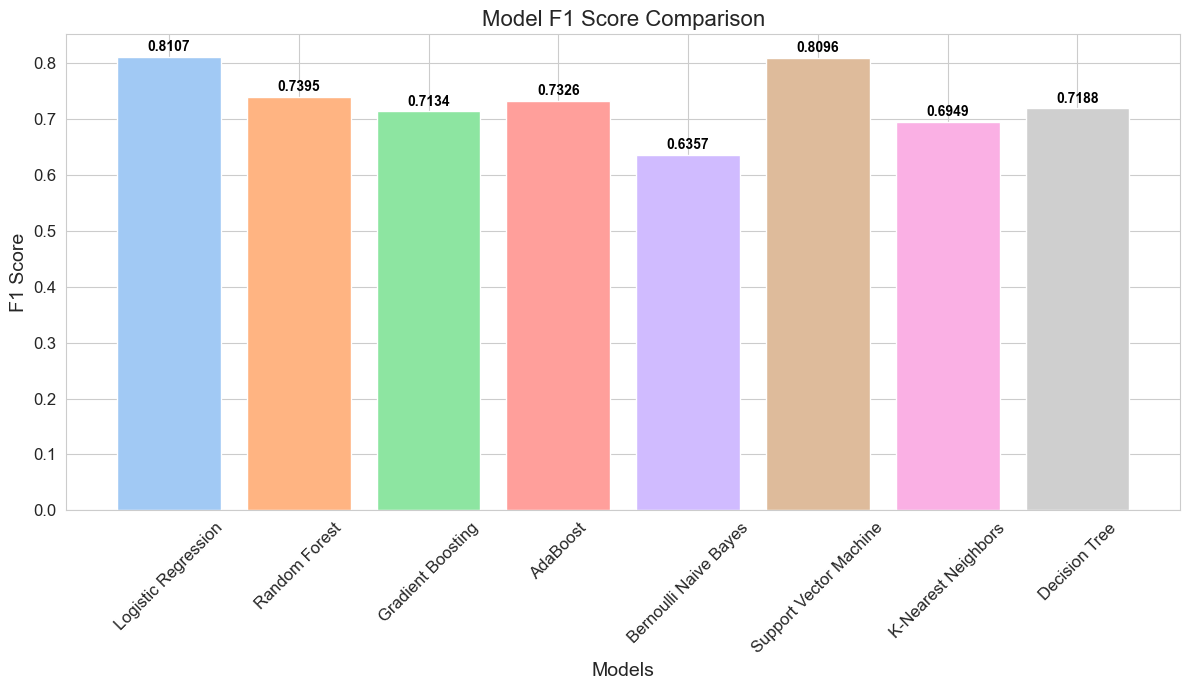

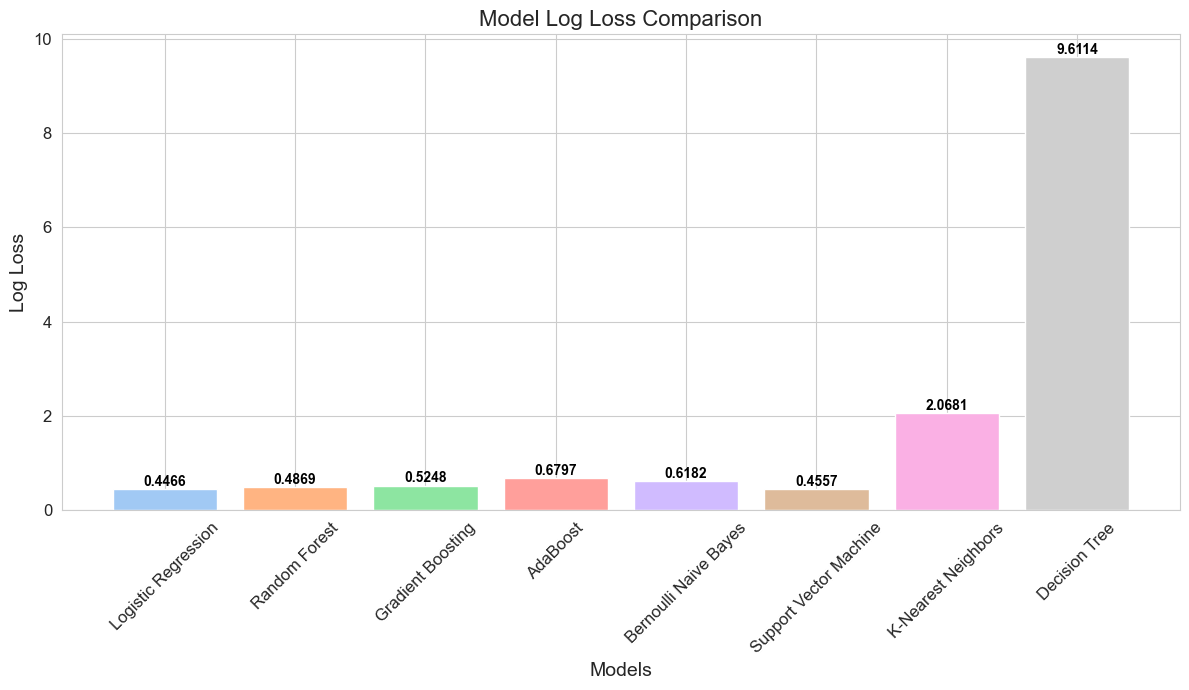

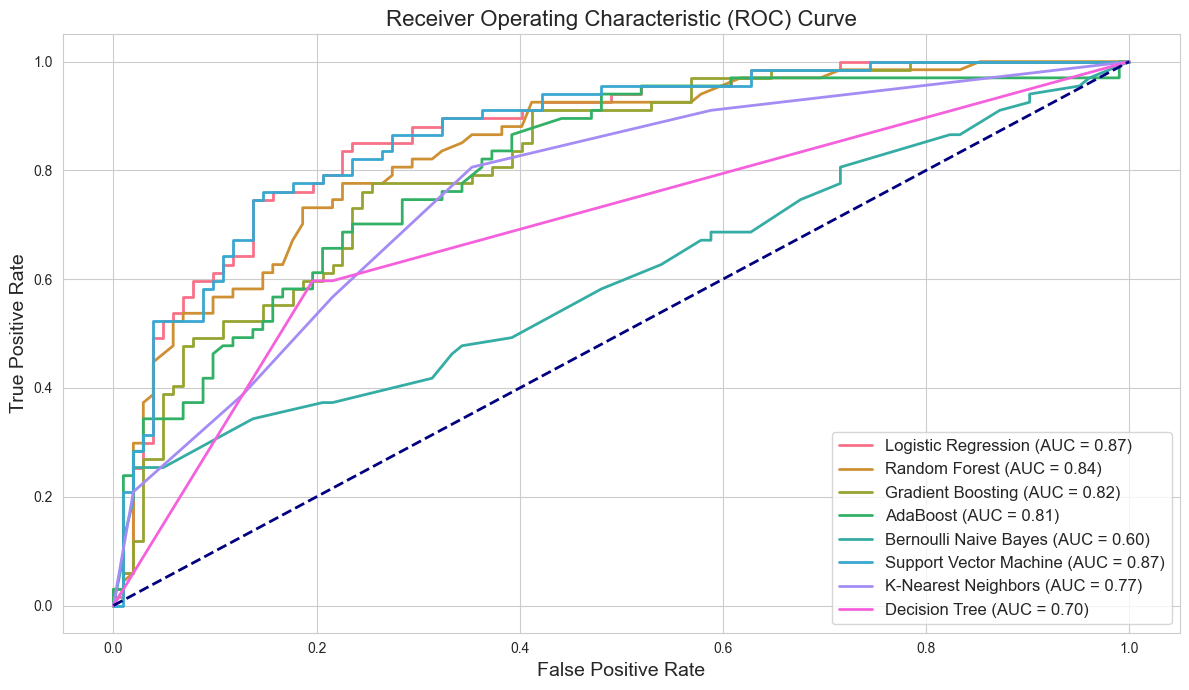

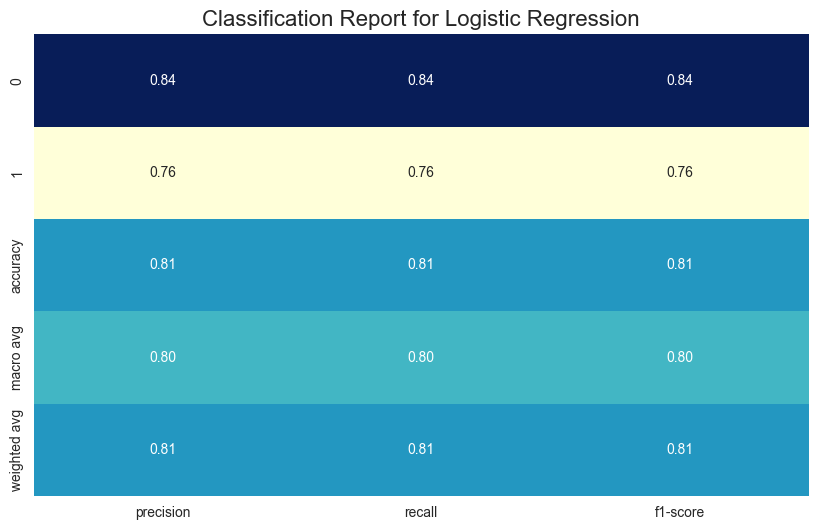

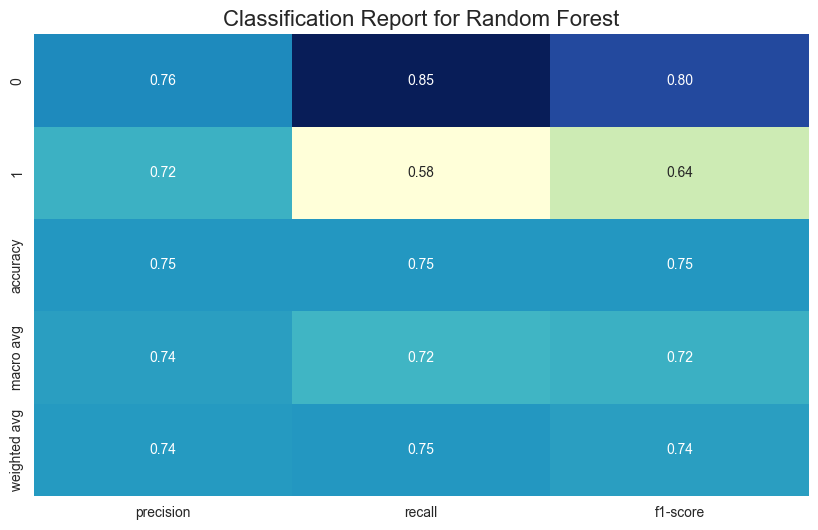

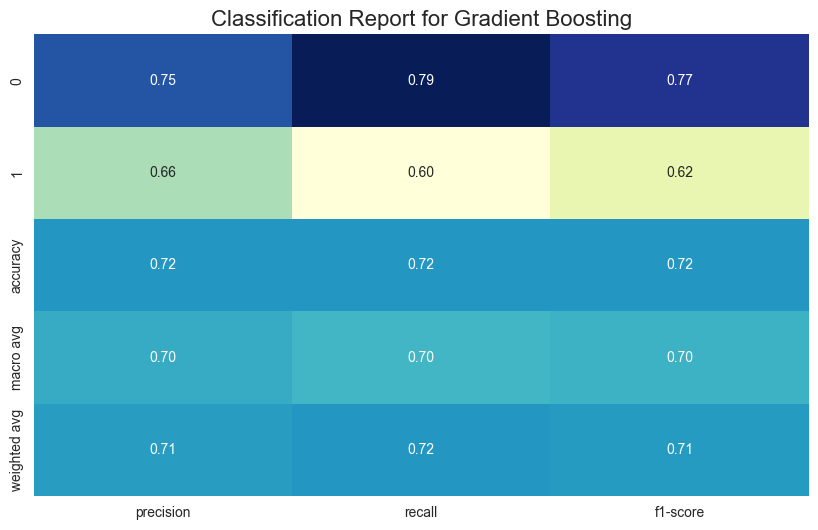

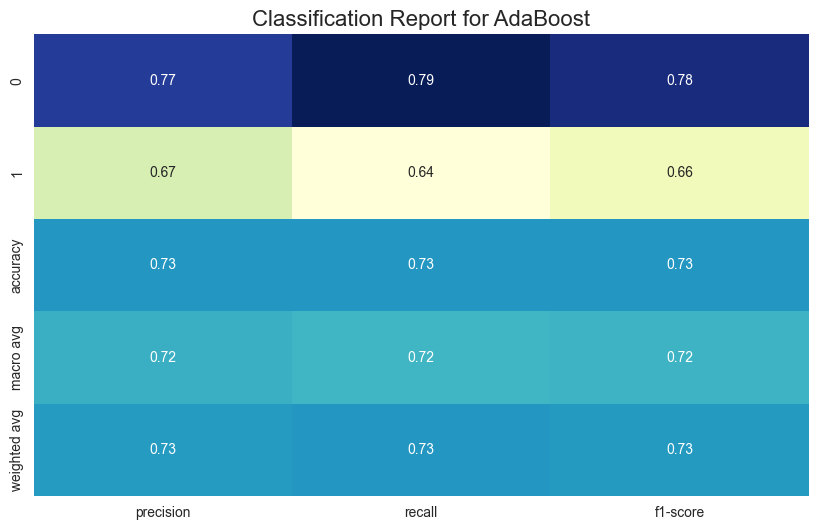

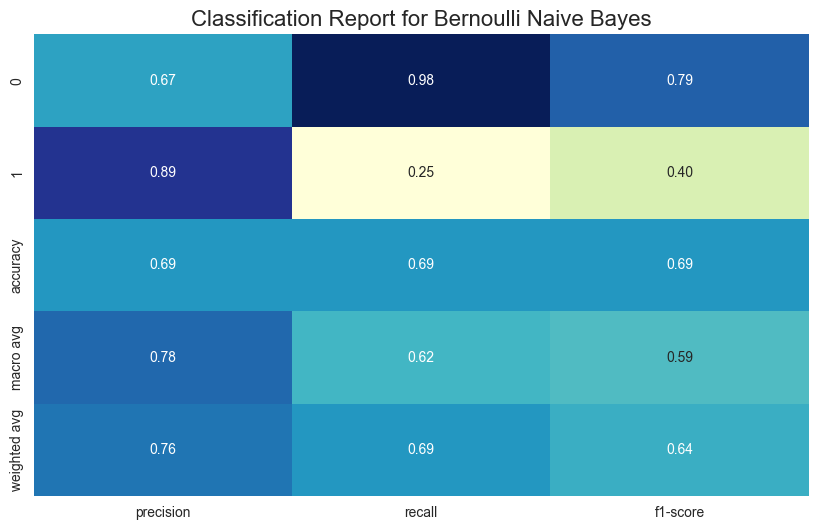

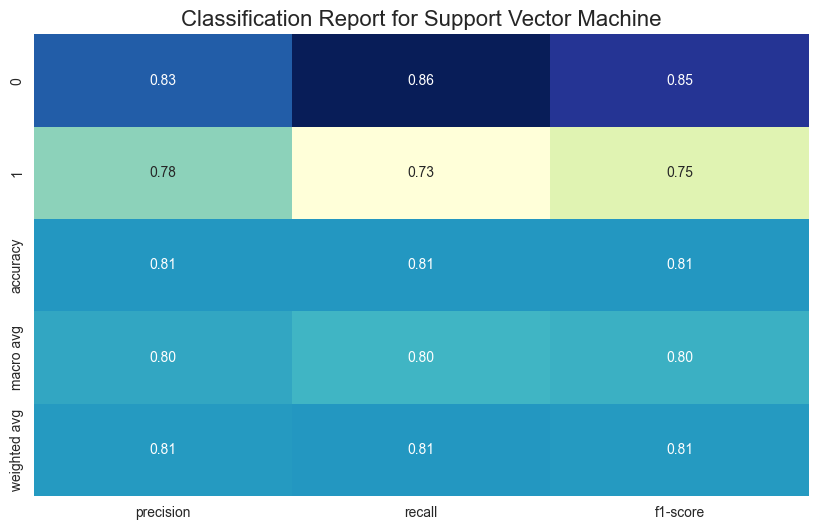

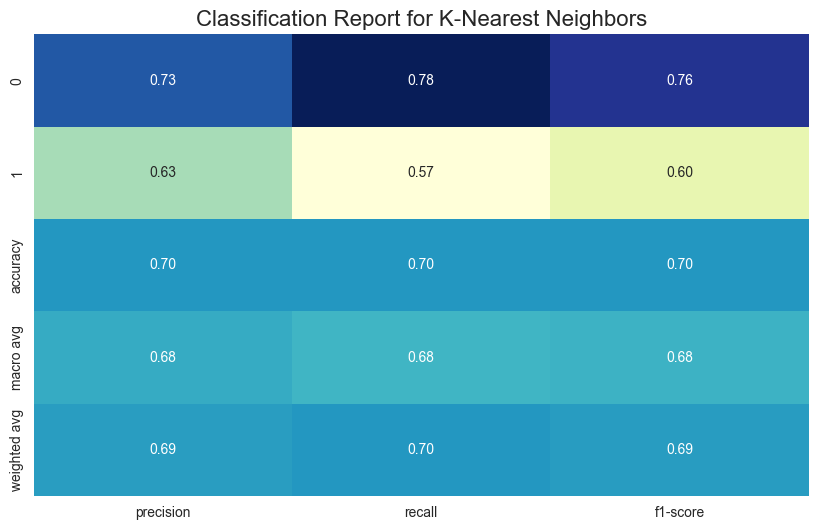

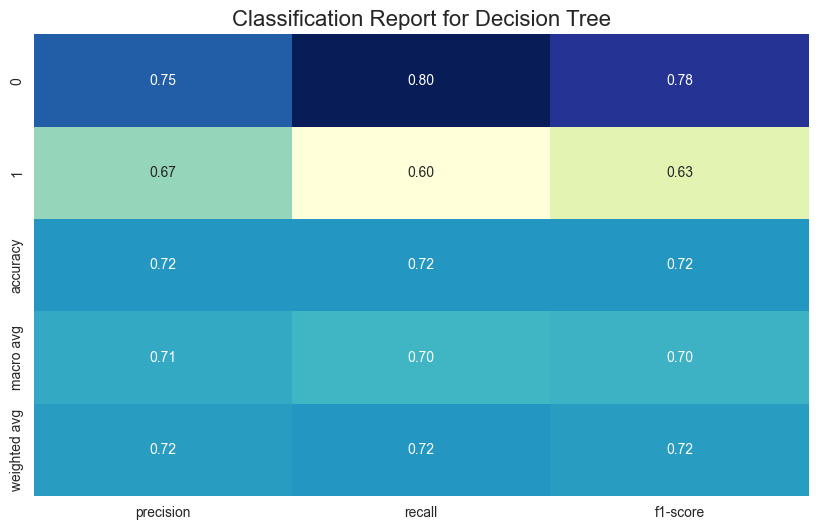

In [45]:
# 1. Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=5000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Bernoulli Naive Bayes': BernoulliNB(),
    'Support Vector Machine': SVC(probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# 2. Train each model
trained_models = {name: train_model(model, X_train, y_train) for name, model in models.items()}

# 3. Evaluate each trained model
model_metrics = {name: evaluate_model(model, X_test, y_test) for name, model in trained_models.items()}
model_accuracies = {name: metrics['Accuracy'] for name, metrics in model_metrics.items()}

# 4. Visualize the results
visualize_metrics(model_metrics)

## Calculating Feature Importance for our models:

In [46]:
def compute_feature_importance(models, X_train, y_train):
    """
    Computes feature importance for a list of models.
    
    Parameters:
    - models: Dictionary of trained models.
    - X_train: Training features.
    - y_train: Training labels.
    
    Returns:
    - Dictionary with model names as keys and feature importances as values.
    """
    feature_importances = {}
    
    for model_name, model in models.items():
        if hasattr(model, "feature_importances_"):
            feature_importances[model_name] = model.feature_importances_
        else:
            # Compute permutation importance
            perm_importance = permutation_importance(model, X_train, y_train)
            feature_importances[model_name] = perm_importance.importances_mean
            
    return feature_importances

In [47]:
def visualize_feature_importance(feature_importances, feature_names):
    """
    Visualizes feature importance for given models.
    
    Parameters:
    - feature_importances: Dictionary containing feature importances for each model.
    - feature_names: Names of the features in the dataset.
    """
    
    for model_name, importances in feature_importances.items():
        sorted_idx = np.argsort(importances)
        
        plt.figure(figsize=(10, len(feature_names) / 2))
        plt.title(f"Feature Importance: {model_name}")
        plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

In [48]:
importances = compute_feature_importance(trained_models, X_train, y_train)

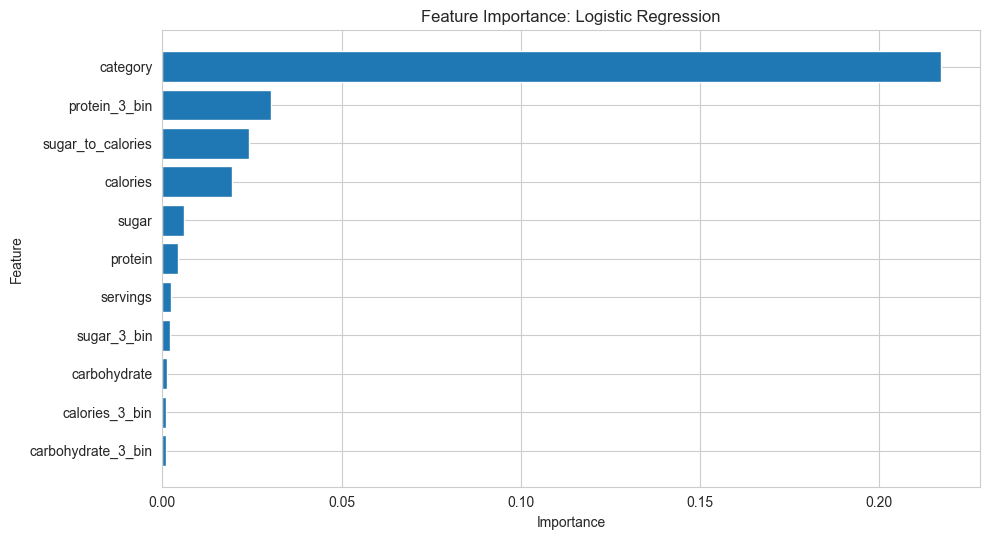

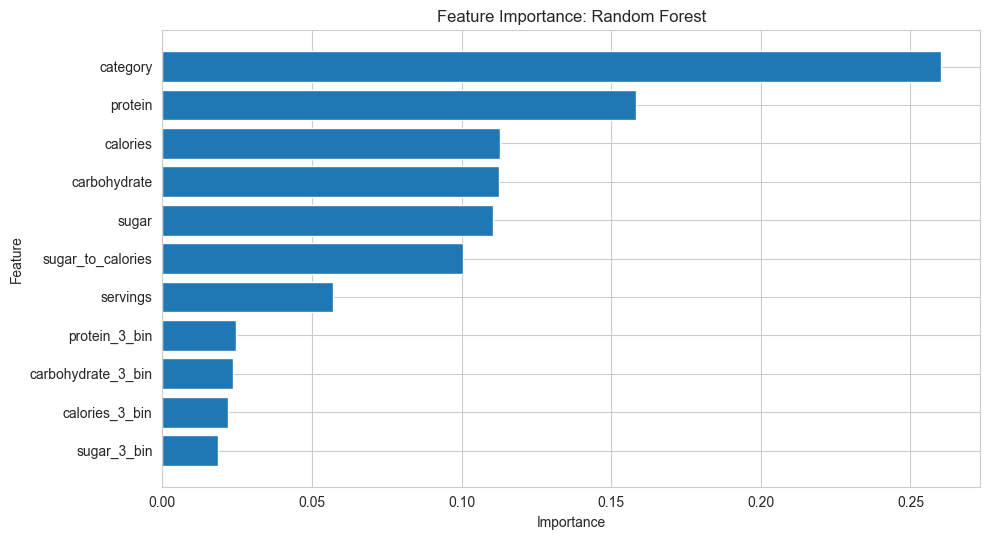

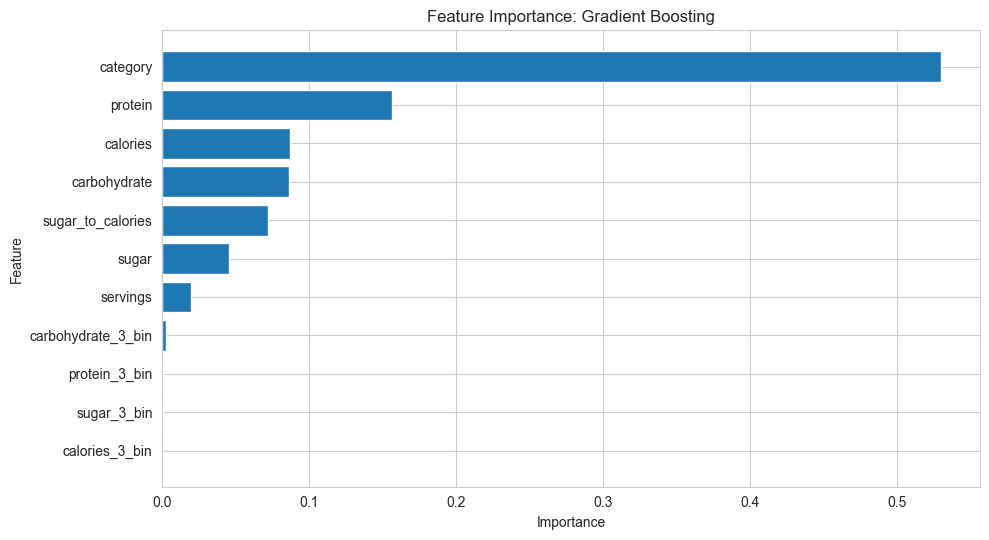

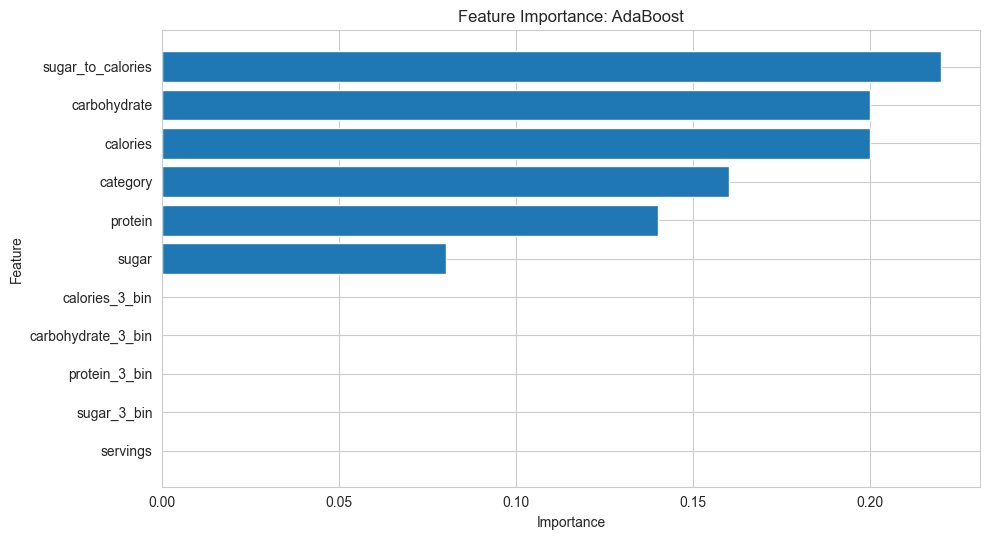

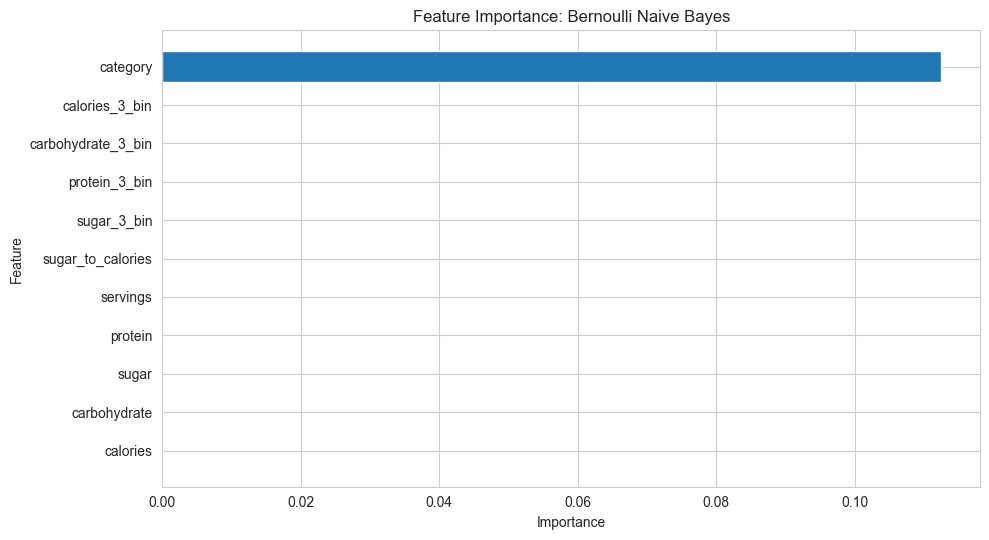

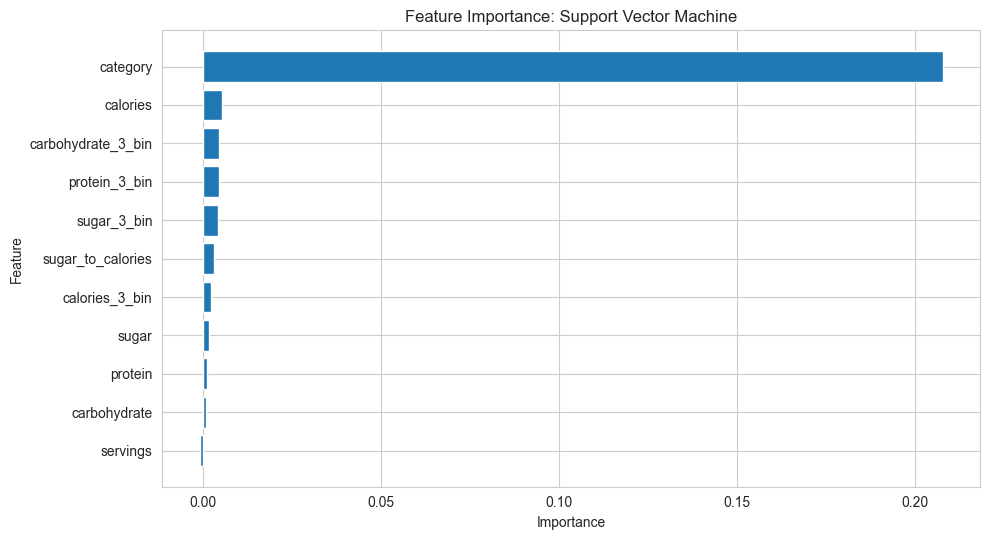

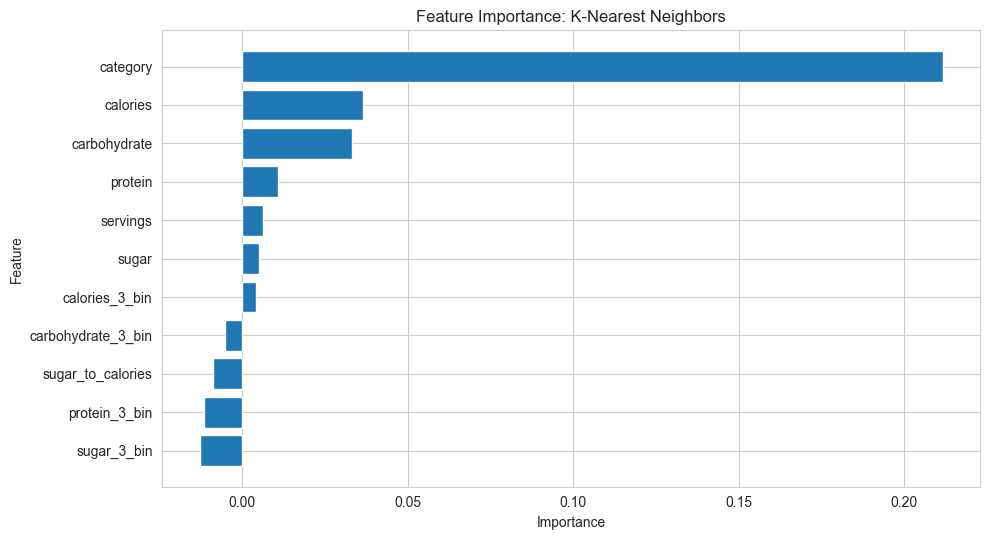

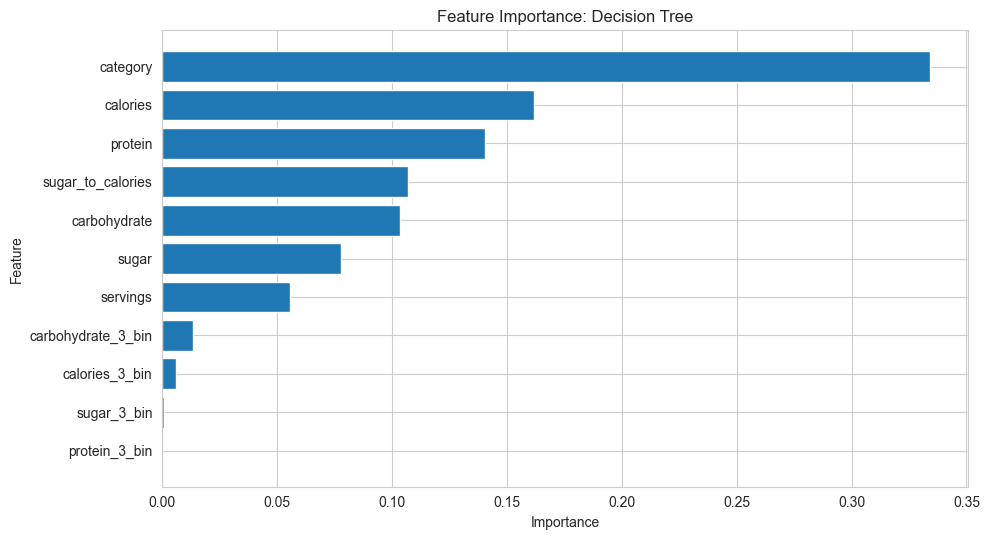

In [49]:
visualize_feature_importance(importances, X_train.columns)

## Defining the Hyperparameters grid and tuning our models:

In [50]:
# Hyperparameter distributions for each model
param_distributions = {
    'Logistic Regression': {
        'C': uniform(0.0001, 1000),
        'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'max_iter': randint(100, 5000),
        'l1_ratio': uniform(0, 1)  # Only used when penalty is 'elasticnet'
    },
    'Random Forest': {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 1500],
        'criterion': ['gini', 'entropy'],
        'max_features': ['auto', 'sqrt', 'log2', None, 0.25, 0.5, 0.75],
        'max_depth': [None] + list(range(1, 51)),
        'min_samples_split': list(range(2, 21)),
        'min_samples_leaf': list(range(1, 21)),
        'bootstrap': [True, False],
        'oob_score': [True, False],
        'class_weight': [None, 'balanced', 'balanced_subsample'],
        'min_impurity_decrease': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        'max_samples': [None, 0.25, 0.5, 0.75],
        'max_leaf_nodes': [None] + list(range(2, 102)),
        'ccp_alpha': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]
    },
    'Gradient Boosting': {
        'n_estimators': randint(10, 500),
        'learning_rate': uniform(0.01, 1),
        'subsample': uniform(0.5, 0.5),
        'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
        'max_features': ['auto', 'sqrt', 'log2'],
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20)
    },
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'splitter': ['best', 'random'],
        'max_depth': [None] + list(randint(1, 50).rvs(10)),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 20)
    },
    'Support Vector Machine': {
        'C': uniform(0.1, 10),
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': randint(1, 10),  # Degree of the polynomial kernel. Ignored by other kernels
        'gamma': ['scale', 'auto'] + list(uniform(0.1, 5).rvs(5)),  # Kernel coefficient. 'scale', 'auto', or float
        'coef0': uniform(0, 5),  # Independent term in kernel function. Only significant in 'poly' and 'sigmoid'
        'shrinking': [True, False],
        'probability': [True],  # Whether to enable probability estimates. This must be True for multi-class classification
        'tol': uniform(1e-6, 1e-4),  # Tolerance for stopping criterion
        'max_iter': [-1] + list(randint(100, 2000).rvs(5))  # -1 means no limit
    },
    'K-Nearest Neighbors': {
        'n_neighbors': randint(1, 50),
        'weights': ['uniform', 'distance'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'leaf_size': randint(10, 50),
        'p': [1, 2],  # 1 is Manhattan, 2 is Euclidean
        'metric': ['minkowski', 'euclidean', 'manhattan']
    },
    'AdaBoost': {
    'n_estimators': randint(10, 500),
    'learning_rate': uniform(0.01, 2)
    },
    'Bernoulli Naive Bayes': {
    'alpha': uniform(0, 2),
    'fit_prior': [True, False],
    'binarize': uniform(0, 1)  # Threshold for binarizing the input features
    }
}

best_models = {}
for name, model in models.items():
    random_search = RandomizedSearchCV(model, param_distributions=param_distributions[name], n_iter=50, scoring='accuracy', n_jobs=-1, cv=5, random_state=42, verbose=1)
    random_search.fit(X_train, y_train)
    best_models[name] = random_search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


## Evaluating tuned models:

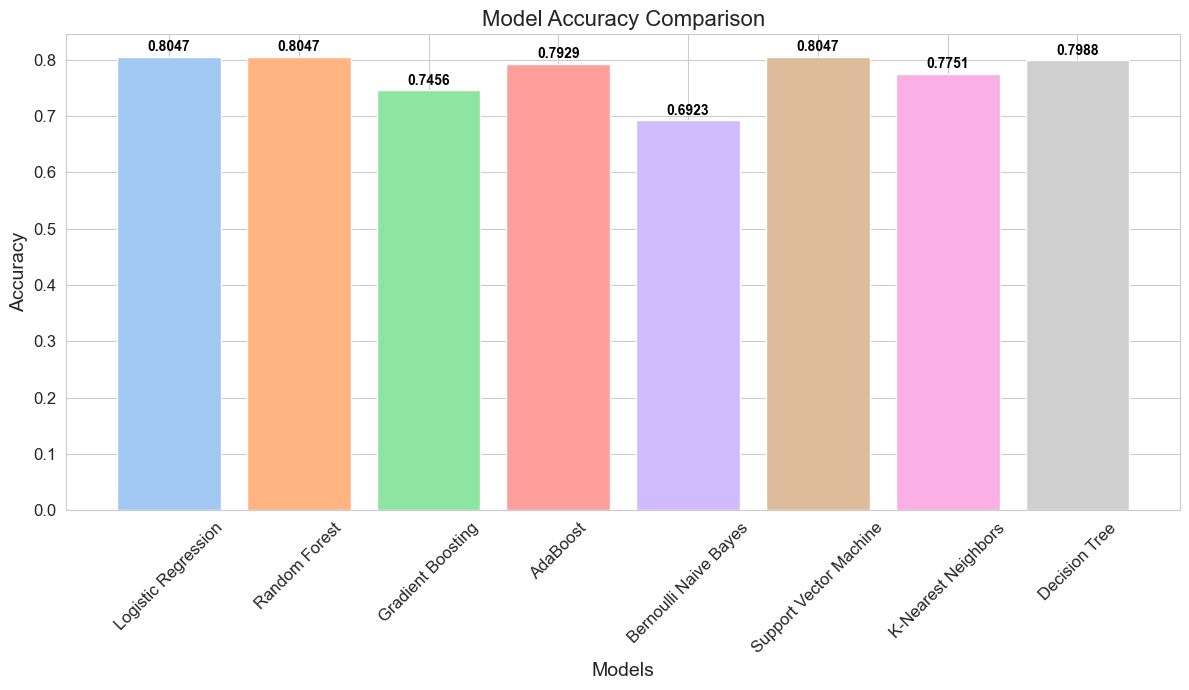

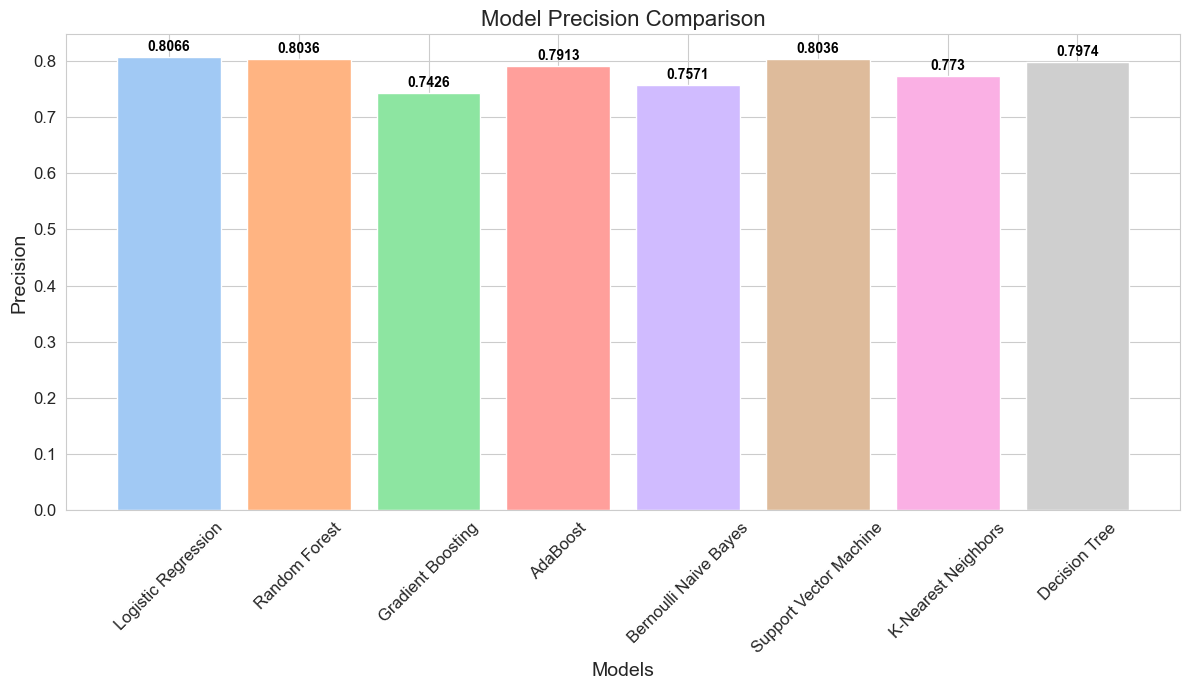

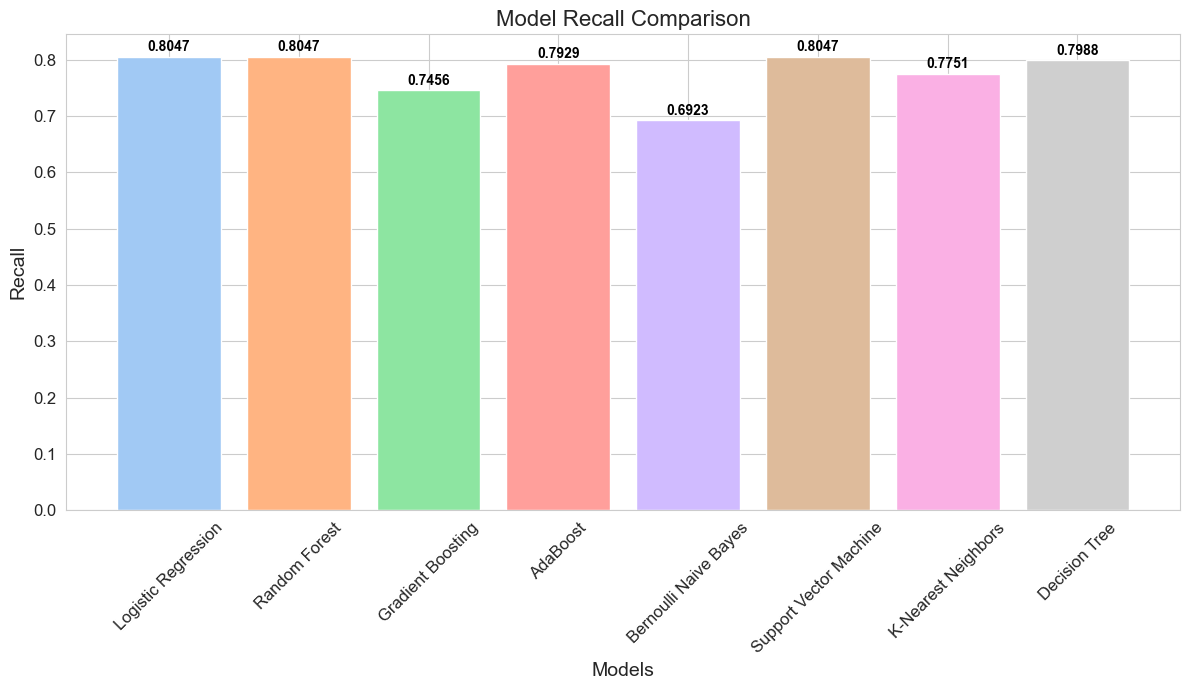

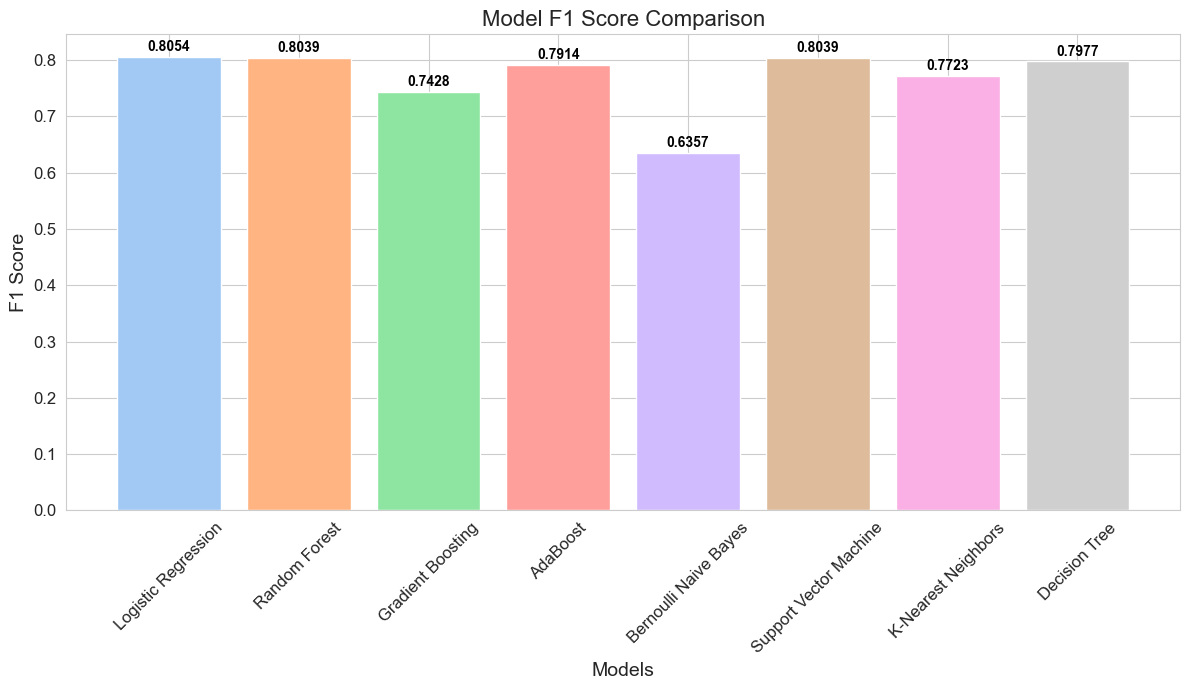

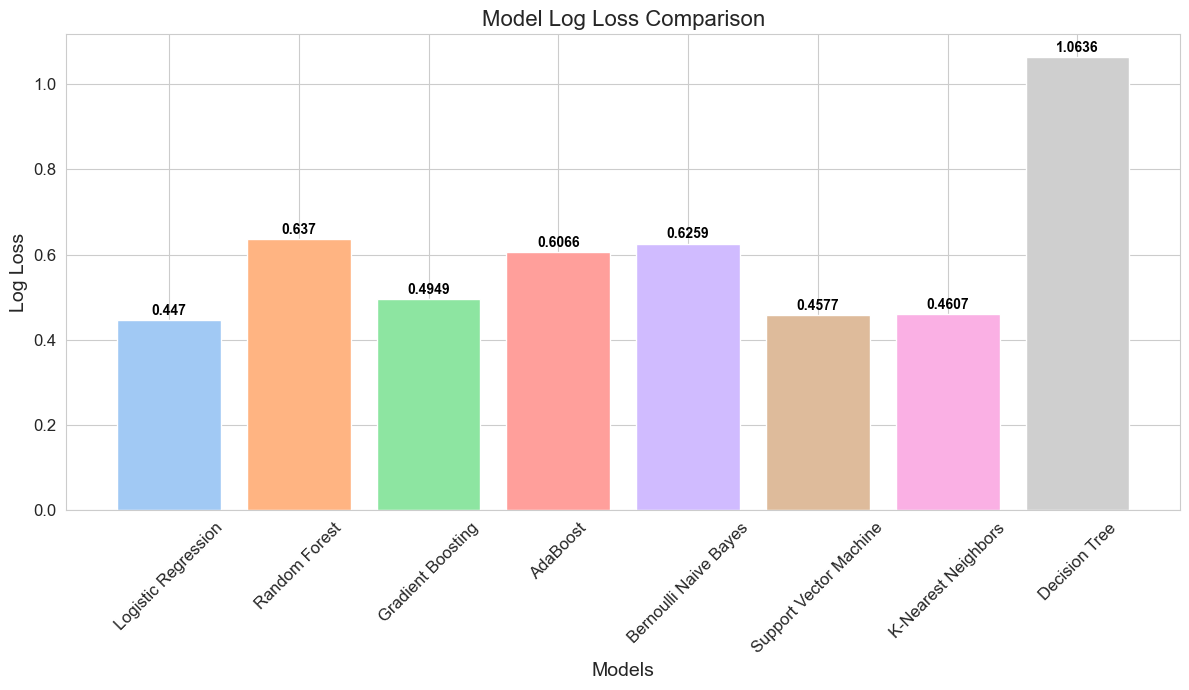

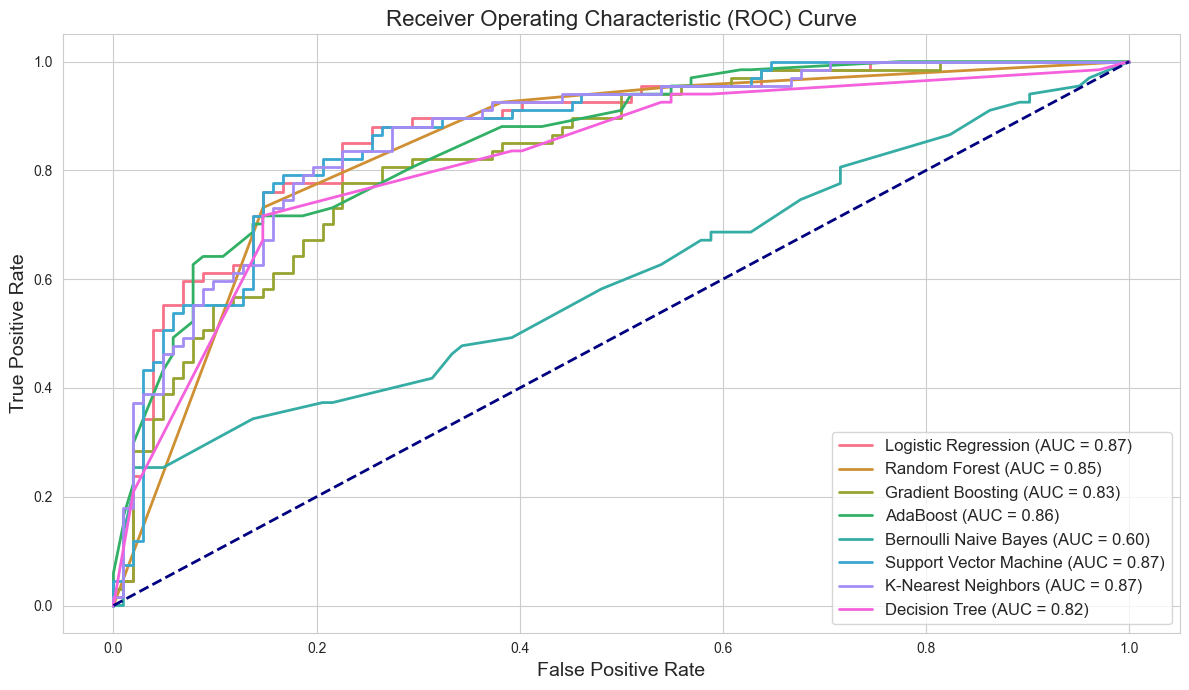

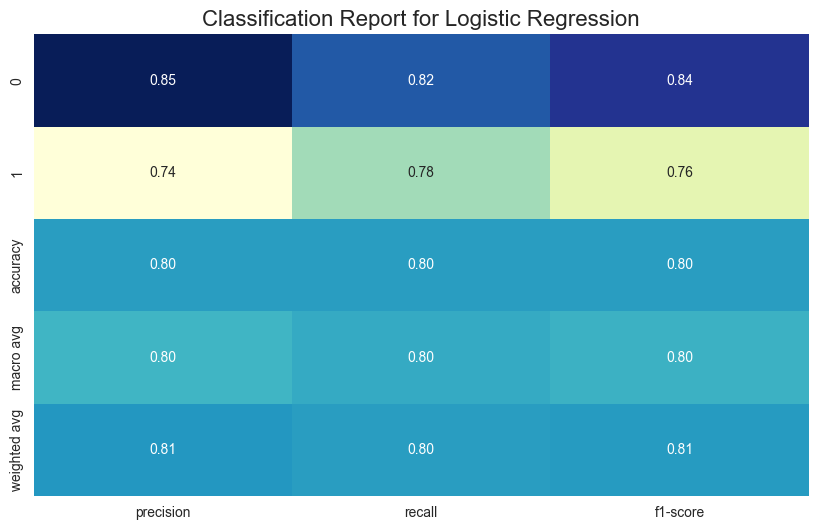

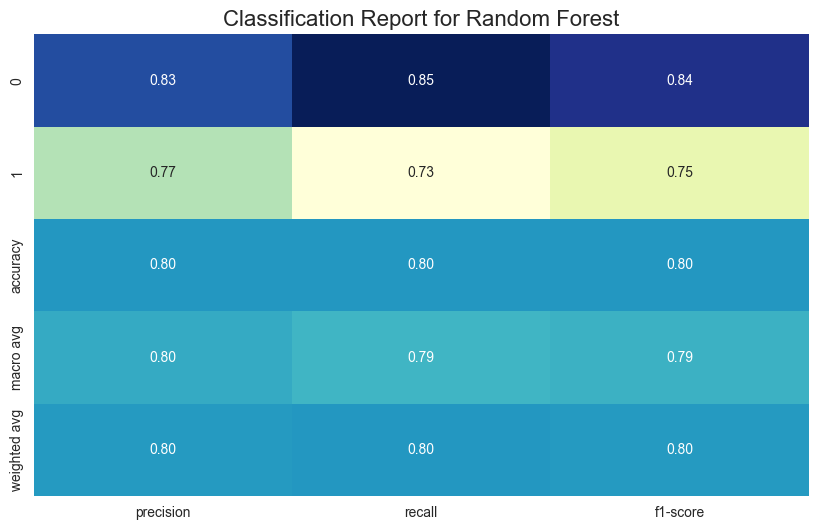

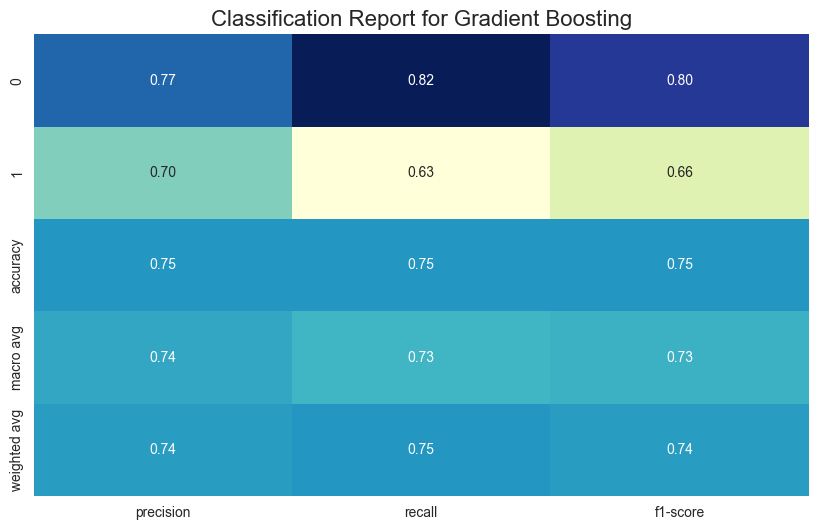

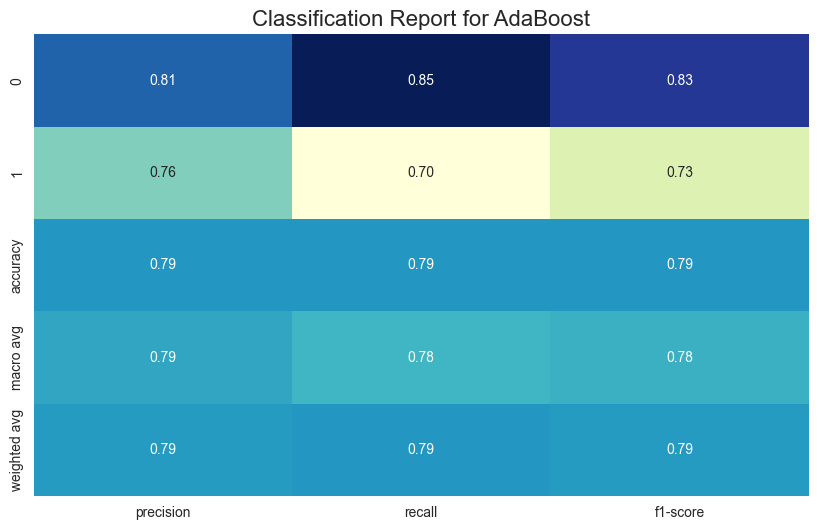

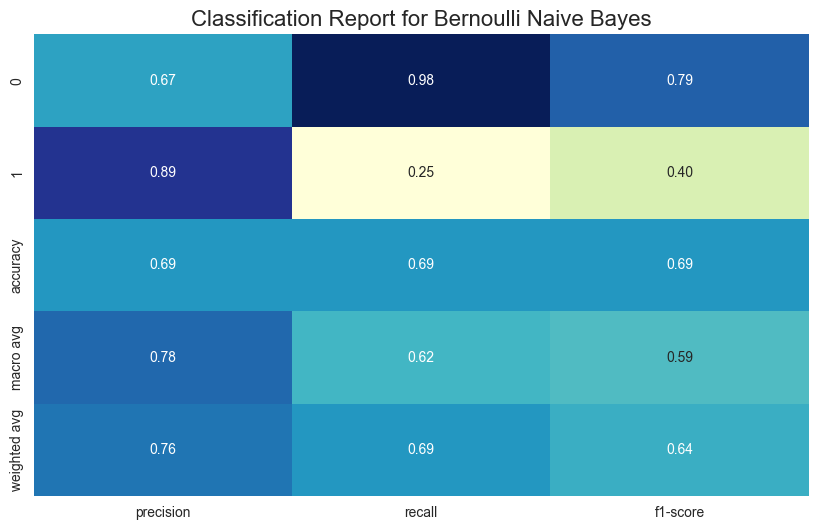

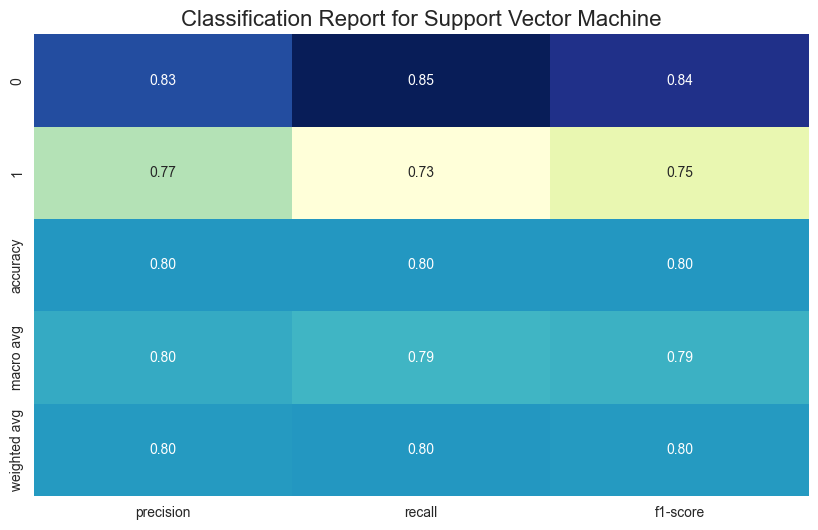

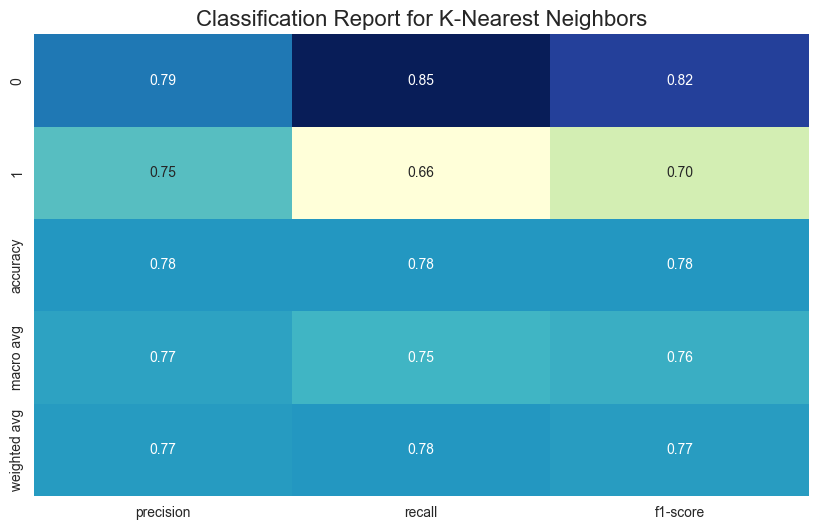

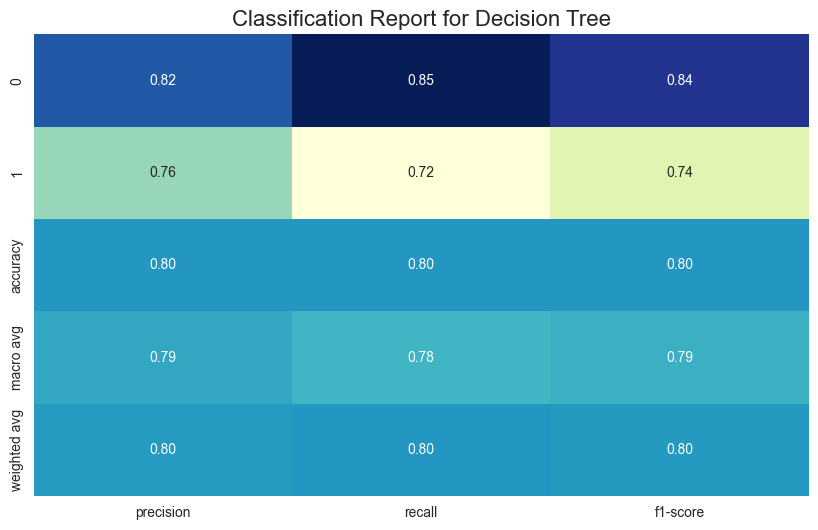

In [51]:
# 1. Train each model
best_models = {name: train_model(model, X_train, y_train) for name, model in best_models.items()}

# 2. Evaluate each trained model
best_models_metrics = {name: evaluate_model(model, X_test, y_test) for name, model in best_models.items()}
best_models_accuracies = {name: metrics['Accuracy'] for name, metrics in model_metrics.items()}

# 3. Visualize the results
visualize_metrics(best_models_metrics)

# Model Ranking Methodology:
Objective: Rank models based on a holistic evaluation using multiple performance metrics.

### Steps:

### Metrics Utilized:

Positive Metrics: Accuracy, Precision, Recall, F1 Score, ROC AUC. (Higher values indicate better performance.)
Negative Metrics: Log Los. (Lower values indicate better performance.)
### Evaluation:

Models were assessed using the above metrics both before and after hyperparameter tuning.
### Averaged Rankings:

For "Positive Metrics", models with higher average values ranked better.
For "Negative Metrics", models with lower average values (lesser errors) ranked higher.
### Combined Ranking:

Ranks from both metric types were averaged to give each model a combined rank.
Models were ordered based on this combined rank for both pre and post-tuning stages.

**Rationale**: This approach ensures a balanced evaluation, preventing over-reliance on a single metric and providing a comprehensive view of model performance.

In [52]:
model_metrics_df = pd.DataFrame(model_metrics)
model_metrics_df

,Logistic Regression,Random Forest,Gradient Boosting,AdaBoost,Bernoulli Naive Bayes,Support Vector Machine,K-Nearest Neighbors,Decision Tree
Accuracy,0.810651,0.745562,0.715976,0.733728,0.692308,0.810651,0.698225,0.721893
Precision,0.810651,0.742924,0.71263,0.731961,0.757085,0.80941,0.694058,0.718347
Recall,0.810651,0.745562,0.715976,0.733728,0.692308,0.810651,0.698225,0.721893
F1 Score,0.810651,0.739515,0.713377,0.732608,0.635744,0.809558,0.694914,0.718842
Log Loss,0.446594,0.486893,0.524801,0.679666,0.618157,0.455713,2.068069,9.611357
Classification Report,"{'0': {'precision': 0.8431372549019608, 'recal...","{'0': {'precision': 0.7565217391304347, 'recal...","{'0': {'precision': 0.75, 'recall': 0.79411764...","{'0': {'precision': 0.7714285714285715, 'recal...","{'0': {'precision': 0.6666666666666666, 'recal...","{'0': {'precision': 0.8301886792452831, 'recal...","{'0': {'precision': 0.7339449541284404, 'recal...","{'0': {'precision': 0.7522935779816514, 'recal..."
ROC AUC,0.868891,0.843723,0.81592,0.806482,0.601697,0.870354,0.765876,0.696517
fpr,"[0.0, 0.0, 0.00980392156862745, 0.009803921568...","[0.0, 0.00980392156862745, 0.00980392156862745...","[0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...","[0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...","[0.0, 0.00980392156862745, 0.00980392156862745...","[0.0, 0.00980392156862745, 0.00980392156862745...","[0.0, 0.0196078431372549, 0.12745098039215685,...","[0.0, 0.19607843137254902, 0.21568627450980393..."
tpr,"[0.0, 0.014925373134328358, 0.0149253731343283...","[0.0, 0.029850746268656716, 0.0447761194029850...","[0.0, 0.014925373134328358, 0.0298507462686567...","[0.0, 0.014925373134328358, 0.0298507462686567...","[0.0, 0.08955223880597014, 0.11940298507462686...","[0.0, 0.0, 0.208955223880597, 0.20895522388059...","[0.0, 0.208955223880597, 0.3880597014925373, 0...","[0.0, 0.5970149253731343, 0.5970149253731343, ..."


In [53]:
best_model_metrics_df = pd.DataFrame(best_models_metrics)
best_model_metrics_df

,Logistic Regression,Random Forest,Gradient Boosting,AdaBoost,Bernoulli Naive Bayes,Support Vector Machine,K-Nearest Neighbors,Decision Tree
Accuracy,0.804734,0.804734,0.745562,0.792899,0.692308,0.804734,0.775148,0.798817
Precision,0.806609,0.803616,0.742636,0.791272,0.757085,0.803616,0.773011,0.797424
Recall,0.804734,0.804734,0.745562,0.792899,0.692308,0.804734,0.775148,0.798817
F1 Score,0.805414,0.803913,0.742771,0.791363,0.635744,0.803913,0.772252,0.797656
Log Loss,0.44701,0.637049,0.494932,0.606641,0.62593,0.457675,0.460723,1.063585
Classification Report,"{'0': {'precision': 0.8484848484848485, 'recal...","{'0': {'precision': 0.8285714285714286, 'recal...","{'0': {'precision': 0.7706422018348624, 'recal...","{'0': {'precision': 0.8130841121495327, 'recal...","{'0': {'precision': 0.6666666666666666, 'recal...","{'0': {'precision': 0.8285714285714286, 'recal...","{'0': {'precision': 0.7909090909090909, 'recal...","{'0': {'precision': 0.8207547169811321, 'recal..."
ROC AUC,0.870647,0.845917,0.830699,0.855795,0.60199,0.867428,0.866842,0.820676
fpr,"[0.0, 0.0, 0.00980392156862745, 0.009803921568...","[0.0, 0.14705882352941177, 0.38235294117647056...","[0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...","[0.0, 0.0, 0.0, 0.0, 0.00980392156862745, 0.00...","[0.0, 0.00980392156862745, 0.00980392156862745...","[0.0, 0.0, 0.0, 0.00980392156862745, 0.0098039...","[0.0, 0.0, 0.00980392156862745, 0.009803921568...","[0.0, 0.0196078431372549, 0.14705882352941177,..."
tpr,"[0.0, 0.014925373134328358, 0.0149253731343283...","[0.0, 0.7313432835820896, 0.9253731343283582, ...","[0.0, 0.014925373134328358, 0.0298507462686567...","[0.0, 0.014925373134328358, 0.0298507462686567...","[0.0, 0.0, 0.014925373134328358, 0.10447761194...","[0.0, 0.014925373134328358, 0.0447761194029850...","[0.0, 0.014925373134328358, 0.0149253731343283...","[0.0, 0.208955223880597, 0.6716417910447762, 0..."


In [54]:
num_metric_before = model_metrics_df.drop(['fpr', 'tpr'])
num_metric_after = best_model_metrics_df.drop(['fpr', 'tpr'])
num_metric_before = num_metric_before.apply(pd.to_numeric, errors='coerce')
num_metric_after = num_metric_after.apply(pd.to_numeric, errors='coerce')

In [55]:
higher_better_metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC AUC"]
lower_better_metrics = ["Log Loss"]

# Rank for metrics where higher values are better
higher_better_rank_before = num_metric_before.loc[higher_better_metrics].mean().rank(ascending=False)
higher_better_rank_after = num_metric_after.loc[higher_better_metrics].mean().rank(ascending=False)

# Rank for metrics where lower values are better
lower_better_rank_before = num_metric_before.loc[lower_better_metrics].mean().rank()
lower_better_rank_after = num_metric_after.loc[lower_better_metrics].mean().rank()

# Calculate average ranking considering both sets of metrics
total_rank_before = (higher_better_rank_before + lower_better_rank_before) / 2
total_rank_after = (higher_better_rank_after + lower_better_rank_after) / 2

# Combine the rankings
total_combined_ranking_modified = pd.DataFrame({
    'Before Tuning': total_rank_before,
    'After Tuning': total_rank_after,
    'Average Rank': (total_rank_before + total_rank_after) / 2
}).sort_values(by='Average Rank')

total_combined_ranking_modified


,Before Tuning,After Tuning,Average Rank
Logistic Regression,1.0,1.0,1.00
Support Vector Machine,2.0,2.0,2.00
Random Forest,3.0,5.0,4.00
AdaBoost,5.0,4.5,4.75
Gradient Boosting,4.5,5.5,5.00
K-Nearest Neighbors,7.0,4.5,5.75
Bernoulli Naive Bayes,6.5,7.0,6.75
Decision Tree,7.0,6.5,6.75


### Using the approach of calculating multiple metrics and then taking their mean for model ranking has several benefits for stakeholders and model development:

- **Holistic Evaluation**: By considering multiple metrics, we get a more comprehensive view of the model's performance. A single metric might not capture all the nuances of the model's behavior. For instance, accuracy might be high for a model, but if the data is imbalanced, other metrics like precision, recall, or F1 score could provide more insight.

- **Balancing Trade-offs**: Different metrics have different strengths and focus areas. For example, precision focuses on the correctness of positive predictions, while recall emphasizes the coverage of actual positives. By averaging them, we balance the trade-offs between different aspects of performance.

- **Mitigating Bias**: Depending solely on a single metric might lead to biased model evaluation, especially if the metric is not fully representative of the problem's requirements. Averaging multiple metrics reduces this risk.

- **Flexibility**: This approach is flexible and can be adjusted based on the problem's needs. For instance, if certain metrics are more important than others for a specific task, we can assign them weights when calculating the mean.

- **For Stakeholders**: By combining multiple metrics, stakeholders can get a clearer idea of overall model performance. It condenses the information into a single ranking, making it easier to interpret and communicate.

### Results:
The performance metrics of various machine learning models were analyzed both before and after hyperparameter tuning. Post-tuning, the **Logistic Regression
** consistently performed the best across multiple metrics, such as **Accuracy**, **Precision**, **Recall**, and **F1 Score**. On the other hand, models like the **Decision Tree** and **Bernoulli Naive Bayes** were found at the bottom of the rankings, indicating room for improvement or reconsideration of their use.

### Evaluate by Business Criteria:
A key goal in many machine learning endeavors is to ensure that models not only perform well statistically but also align with business objectives and practical usability. In this context, metrix like **Log Loss** is particularly crucial. **A lower Log Loss, for instance, signifies that the model's predictions are, on average, closer to the actual outcomes**. Similarly, **a lower Log Loss indicates better probabilistic predictions**.


When analyzing **improvements post-tuning**, **AdaBoost** and **Decision Tree** demonstrated significant enhancements in their performance metrics. This is a testament to the power of hyperparameter tuning and its ability to squeeze out additional performance from models.

### Recommendation:

For practical business applications, achieving a balance between predictive accuracy and model interpretability is paramount. **Logistic Regression** stands out in this regard due to its transparent nature. It not only provides probabilities that can be easily interpreted but also allows for an understanding of the relationship between features and the predicted outcome through its coefficients. This makes it easier for stakeholders to grasp how different variables influence predictions. Furthermore, its consistent performance across various datasets underscores its reliability as a go-to model for binary and multiclass classification tasks in business contexts.

To harness the power of machine learning for better decision-making:

- **Pilot Phase**: Begin by integrating the **Logistic Regression** model into a pilot phase, comparing its predictions with real-world outcomes.
- **Error Analysis**: In cases of discrepancies, conduct a thorough error analysis to understand the root causes.
- **Deployment**: Consider deploying the model through user-friendly interfaces, such as web or mobile applications, making it accessible to decision-makers and stakeholders.
- **Continuous Improvement**: As more data becomes available, continuously retrain and refine the model. Consider exploring ensemble methods or deep learning approaches if the data volume grows significantly.
- **Feedback Loop**: Establish a feedback loop with the users of the model, ensuring that any practical challenges they face are addressed in subsequent iterations.
By following these steps, the organization can ensure that the deployed machine learning models remain relevant, accurate, and beneficial to the decision-making process.